# Simple classifier with feature engineering

## Import

### Import modules

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas
import math
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score
import root_numpy
import time
from __future__ import division
import seaborn as sns
sns.set_style("white")
import random
import os
import sklearn.utils
from sklearn.pipeline import Pipeline
import json
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from rep.estimators import XGBoostClassifier
import glob

## Globals

In [2]:
quark = 1
gluon = 0
gluonsToQuarks = 2.2383613798
std_used = [0, 0]
mod_used = [0, 0]
ratios = True

### Import data

In [3]:
def loadData(mode, sample, n, v, dataLoc, treename):
    load = dataLoc + mode + "_" + sample + ".root"
    start = None
    stop = None
    if n != -1: 
        if mode == "gluons":
            if sample == "standard":
                start = std_used[0]
                std_used[0] += n
            else:
                start = mod_used[0]
                mod_used[0] += n
        else:
            if sample == "standard":
                start = std_used[1]
                std_used[1] += n
            else:
                start = mod_used[1]
                mod_used[1] += n
        stop = start+n
    if v: print "Loading", n, "events from sample", load, "starting from event", start
    newData = pandas.DataFrame(root_numpy.root2array(load, treename = "treeJets", start=start, stop=stop))
    cutData = newData[(newData.ntracks > 0) & (newData.ntowers > 0)].copy()
    processData(cutData, mode)
    return cutData
    
def loadPairData(sample, n=10000, v=0, dataLoc = "../../data/", treename="treeJets"):
    nQuarks = n
    if ratios and not n == -1:
        nQuarks = int(n*gluonsToQuarks)
    quarks = loadData("quarks", sample, nQuarks, v, dataLoc, treename)
    gluons = loadData("gluons", sample, n, v, dataLoc, treename)
    newData = quarks.append(gluons, ignore_index = True)
    newData = sklearn.utils.shuffle(newData).reset_index(drop=True)
    if v: print "Samples contains", len(newData[newData.gen_target == 1]), "quarks and", len(newData[newData.gen_target == 0]), "gluons"
    if v: print len(newData), "events in total"
    newData.replace([np.inf, -np.inf], np.nan)
    newData.dropna(how='any') 
    return newData

## Configure data

### Add classification targets and combine into single dataset

In [4]:
def processData(inData, mode):
    if mode == 'quarks':
        inData["gen_target"] = quark
    else:
        inData["gen_target"] = gluon
    engineerData(inData)

### Feature engineering

In [5]:
def engineerData(inData):
    trackFeatures(inData)
    towerFeatures(inData)

In [6]:
def trackFeatures(inData):
    inData["min_track_pT"] = inData[inData.ntracks > 0]["trackPt"].apply(np.min)
    inData["mean_track_pT"] = inData[inData.ntracks > 0]["trackPt"].apply(np.mean)
    inData["max_track_pT"] = inData[inData.ntracks > 0]["trackPt"].apply(np.max)
    inData["sum_track_pT"] = inData[inData.ntracks > 0]["trackPt"].apply(np.sum)
    inData["min_track_eta"] = inData[inData.ntracks > 0]["trackEta"].apply(np.min)
    inData["mean_track_eta"] = inData[inData.ntracks > 0]["trackEta"].apply(np.mean)
    inData["max_track_eta"] = inData[inData.ntracks > 0]["trackEta"].apply(np.max)
    inData["mean_track_charge"] = inData[inData.ntracks > 0]["trackCharge"].apply(np.mean)

In [7]:
def towerFeatures(inData):
    inData["min_tower_E"] = inData[inData.ntowers > 0]["towerE"].apply(np.min)
    inData["mean_tower_E"] = inData[inData.ntowers > 0]["towerE"].apply(np.mean)
    inData["max_tower_E"] = inData[inData.ntowers > 0]["towerE"].apply(np.max)
    inData["sum_tower_E"] = inData[inData.ntowers > 0]["towerE"].apply(np.sum)
    inData["min_tower_Eem"] = inData[inData.ntowers > 0]["towerEem"].apply(np.min)
    inData["mean_tower_Eem"] = inData[inData.ntowers > 0]["towerEem"].apply(np.mean)
    inData["max_tower_Eem"] = inData[inData.ntowers > 0]["towerEem"].apply(np.max)
    inData["sum_tower_Eem"] = inData[inData.ntowers > 0]["towerEem"].apply(np.sum)
    inData["min_tower_Ehad"] = inData[inData.ntowers > 0]["towerEhad"].apply(np.min)
    inData["mean_tower_Ehad"] = inData[inData.ntowers > 0]["towerEhad"].apply(np.mean)
    inData["max_tower_Ehad"] = inData[inData.ntowers > 0]["towerEhad"].apply(np.max)
    inData["sum_tower_Ehad"] = inData[inData.ntowers > 0]["towerEhad"].apply(np.sum)
    inData["tower_Eem_frac"] = inData.ix[inData.ntowers > 0, "sum_tower_Eem"]/inData.ix[inData.ntowers > 0, "sum_tower_E"]
    inData["tower_Ehad_frac"] = inData.ix[inData.ntowers > 0, "sum_tower_Ehad"]/inData.ix[inData.ntowers > 0, "sum_tower_E"]
    inData["min_tower_eta"] = inData[inData.ntowers > 0]["towerEta"].apply(np.min)
    inData["mean_tower_eta"] = inData[inData.ntowers > 0]["towerEta"].apply(np.mean)
    inData["max_tower_eta"] = inData[inData.ntowers > 0]["towerEta"].apply(np.max)

## Options

### Specify variables

In [8]:
data = loadPairData("standard", 10, 1)

Loading 22 events from sample ../../data/quarks_standard.root starting from event 0
Loading 10 events from sample ../../data/gluons_standard.root starting from event 0
Samples contains 22 quarks and 10 gluons
32 events in total


In [9]:
genFeatures = [gen for gen in data.columns if str.startswith(gen, "gen")]
trainFeatures = [var for var in data.columns if var not in genFeatures + ['trackPt', 'trackEta', 'trackCharge', 'towerE', 'towerEem', 'towerEhad', 'towerEta']]

In [10]:
print trainFeatures

['jetPt', 'jetEta', 'jetPhi', 'jetMass', 'ntracks', 'ntowers', 'trackPhi', 'towerPhi', 'min_track_pT', 'mean_track_pT', 'max_track_pT', 'sum_track_pT', 'min_track_eta', 'mean_track_eta', 'max_track_eta', 'mean_track_charge', 'min_tower_E', 'mean_tower_E', 'max_tower_E', 'sum_tower_E', 'min_tower_Eem', 'mean_tower_Eem', 'max_tower_Eem', 'sum_tower_Eem', 'min_tower_Ehad', 'mean_tower_Ehad', 'max_tower_Ehad', 'sum_tower_Ehad', 'tower_Eem_frac', 'tower_Ehad_frac', 'min_tower_eta', 'mean_tower_eta', 'max_tower_eta']


In [11]:
set0 = ['jetPt', 'jetEta', 'jetMass', 'ntracks', 'ntowers']
set1 = [var for var in trainFeatures if "phi" not in var.lower() and "_frac" not in var.lower()]

In [12]:
classTrainFeatures = set1
classTrainModel = "model0"
normIn = True
pca = True
whiten = False
nSplits = 10
ensembleSize = 10
print "\nTraining on", len(classTrainFeatures), "features:", [var for var in classTrainFeatures]


Training on 28 features: ['jetPt', 'jetEta', 'jetMass', 'ntracks', 'ntowers', 'min_track_pT', 'mean_track_pT', 'max_track_pT', 'sum_track_pT', 'min_track_eta', 'mean_track_eta', 'max_track_eta', 'mean_track_charge', 'min_tower_E', 'mean_tower_E', 'max_tower_E', 'sum_tower_E', 'min_tower_Eem', 'mean_tower_Eem', 'max_tower_Eem', 'sum_tower_Eem', 'min_tower_Ehad', 'mean_tower_Ehad', 'max_tower_Ehad', 'sum_tower_Ehad', 'min_tower_eta', 'mean_tower_eta', 'max_tower_eta']


In [13]:
classWeights = {float(quark) : 1.0/len(data[data.gen_target == quark]),
                float(gluon) : 1.0/len(data[data.gen_target == gluon])}
print "Class weights are: ", classWeights

Class weights are:  {0.0: 0.1, 1.0: 0.045454545454545456}


## Visualise data - Before pre-processing

In [14]:
std = loadPairData("standard", 20000)
mod = loadPairData("modified", 20000)

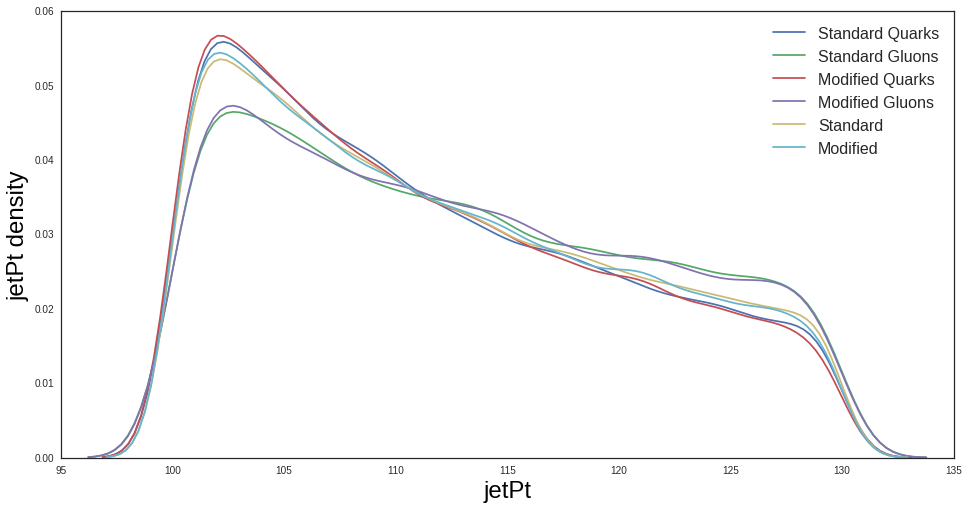

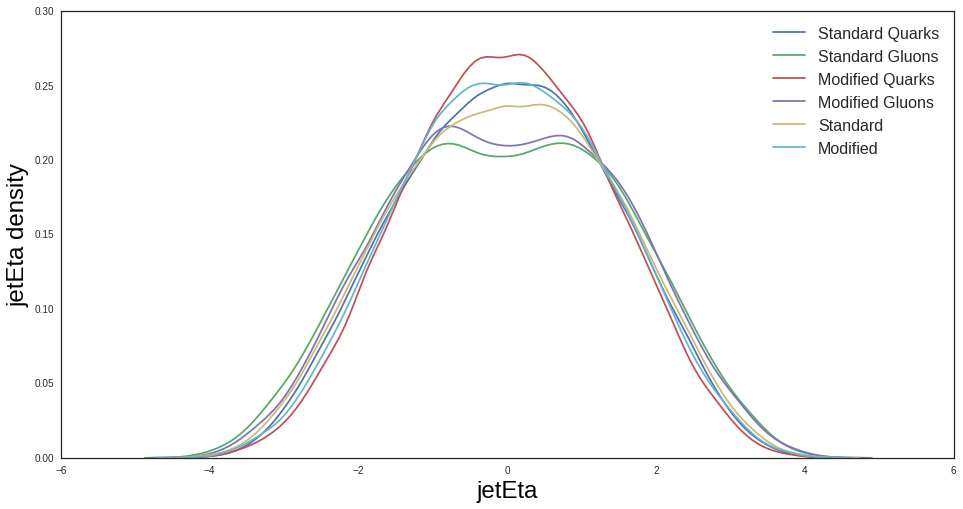

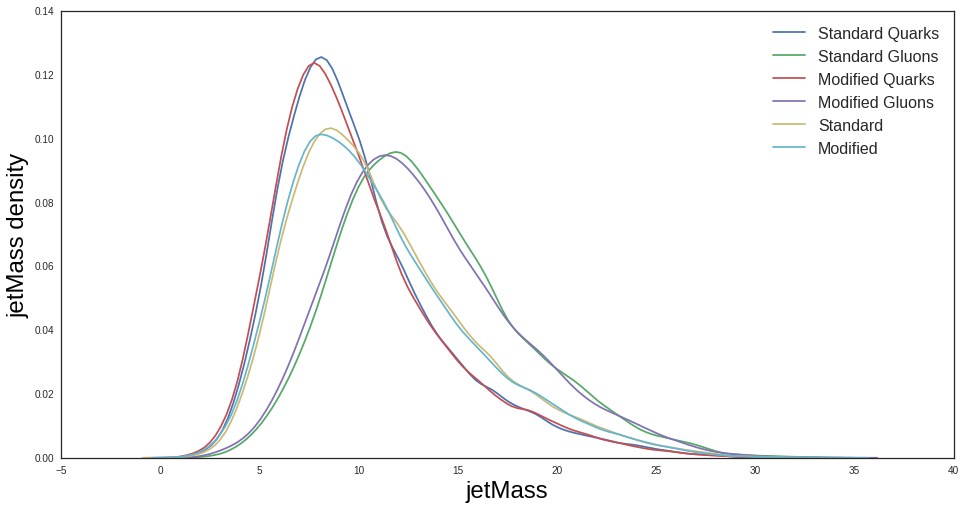

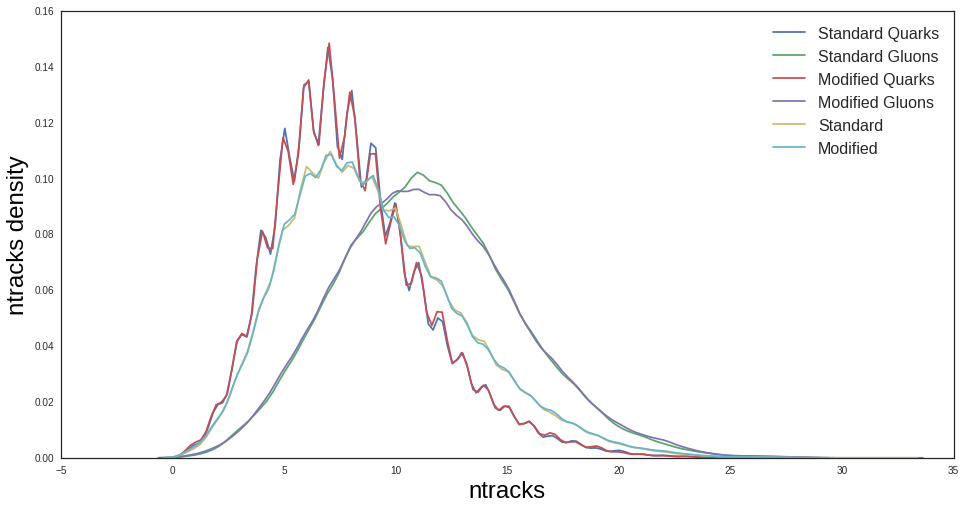

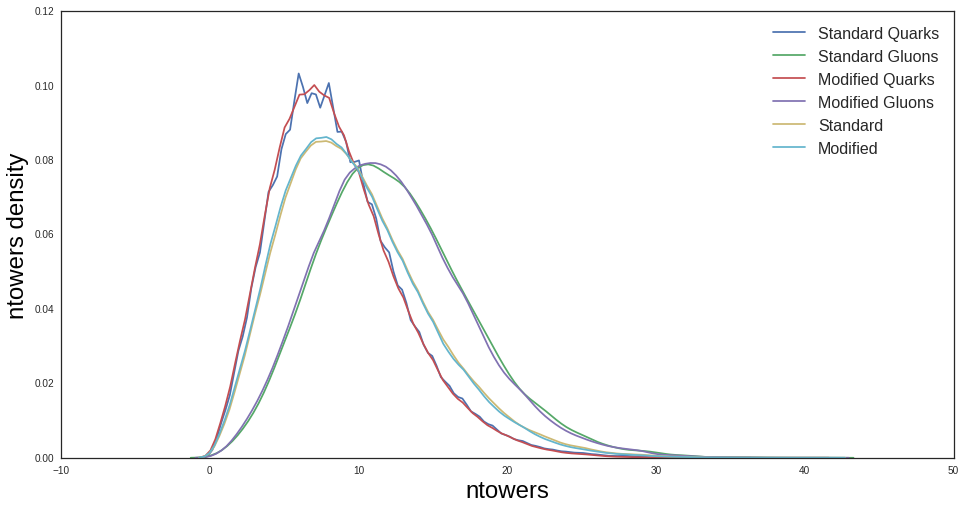

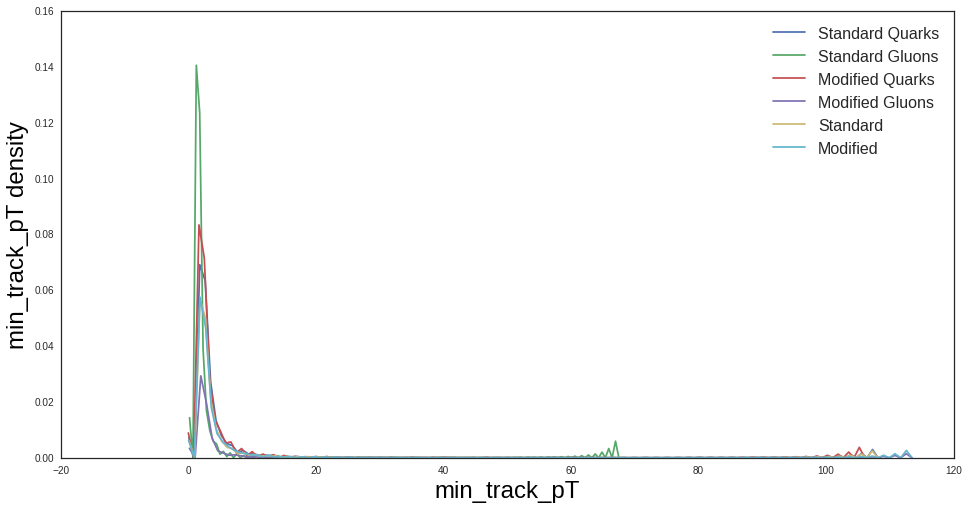

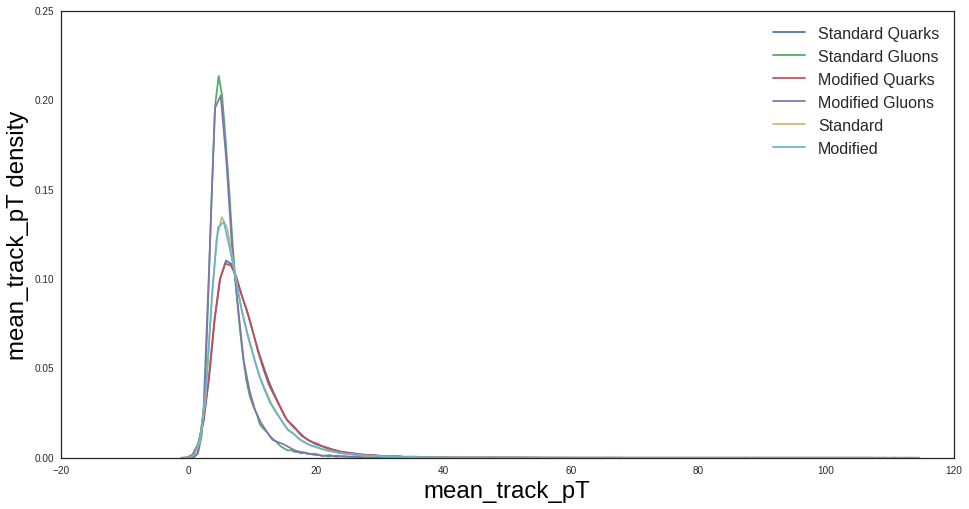

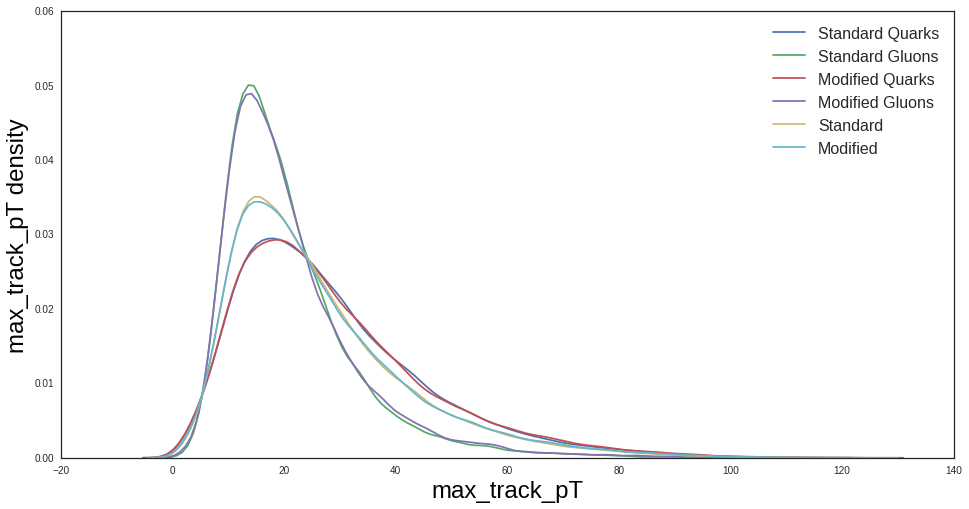

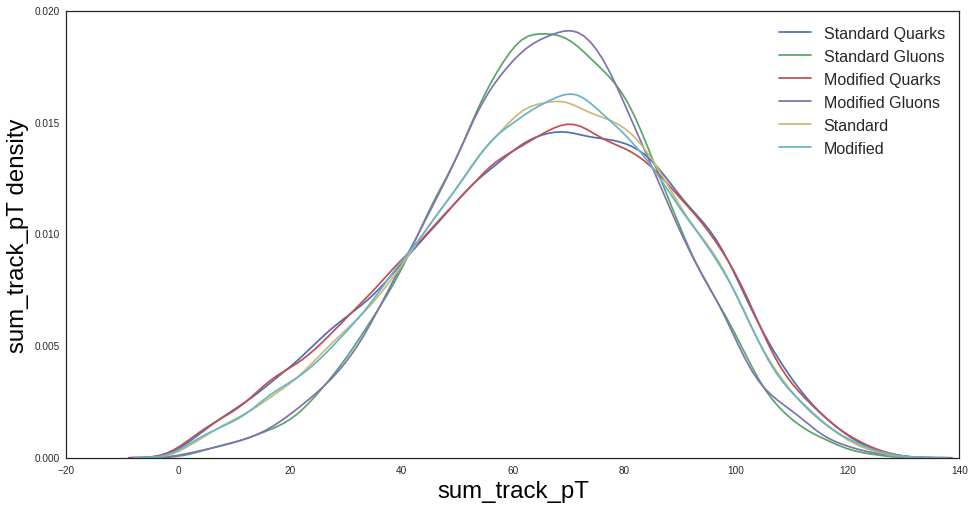

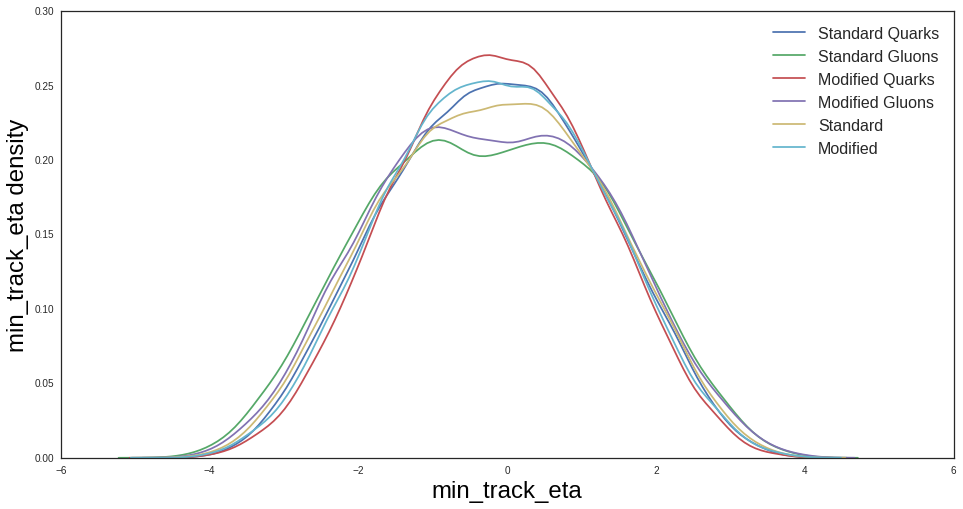

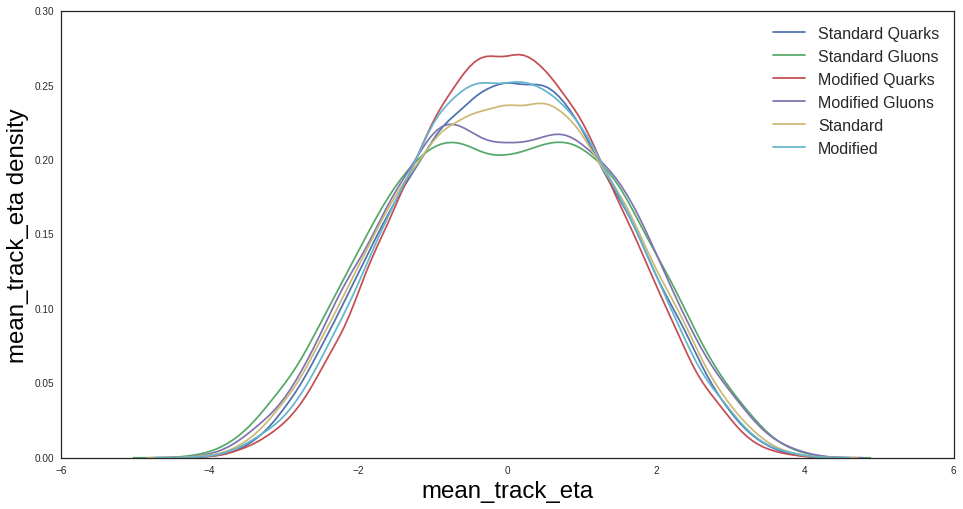

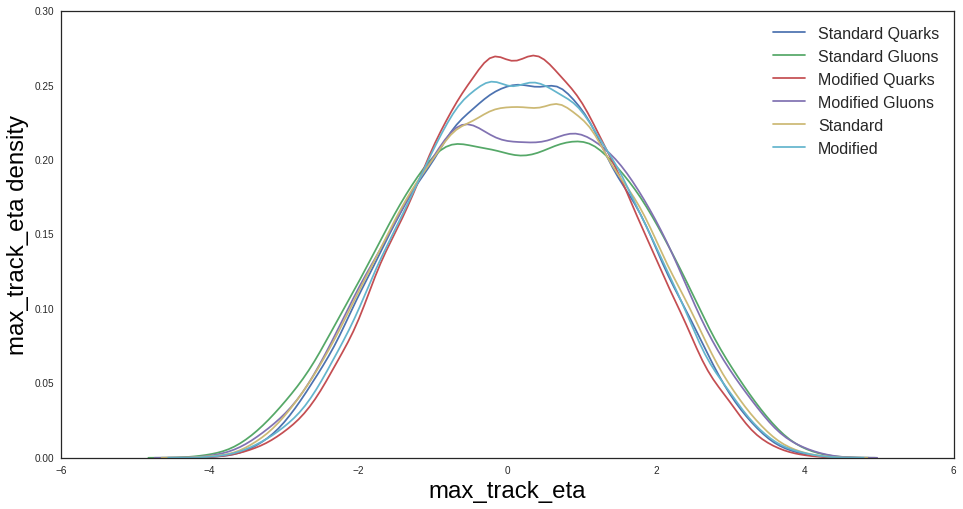

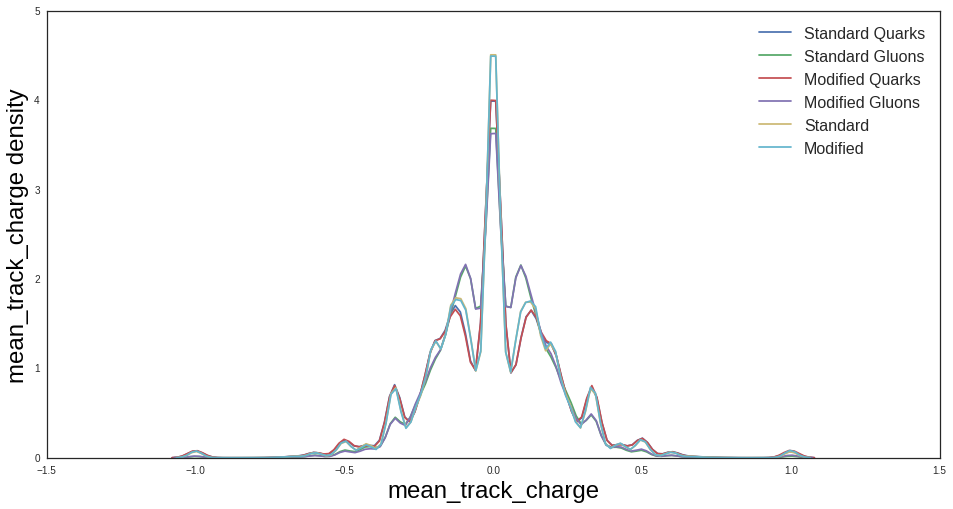

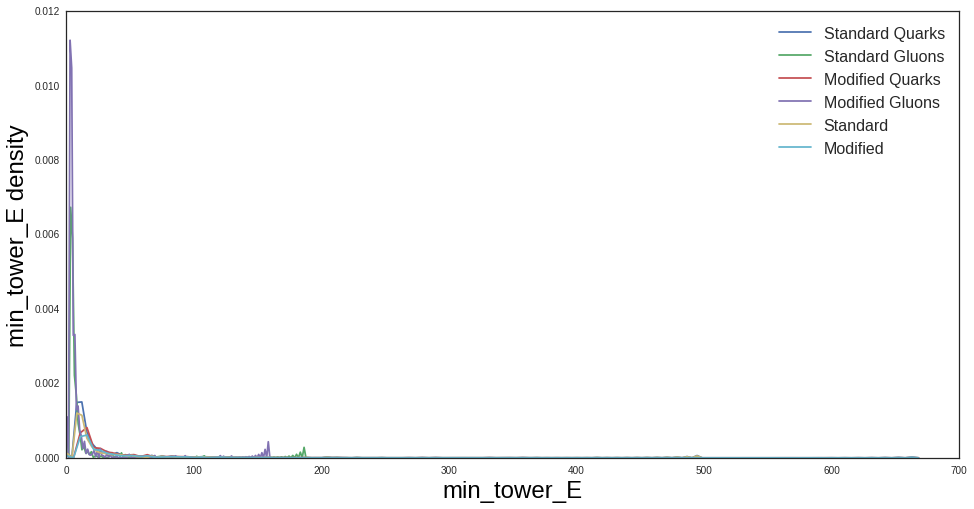

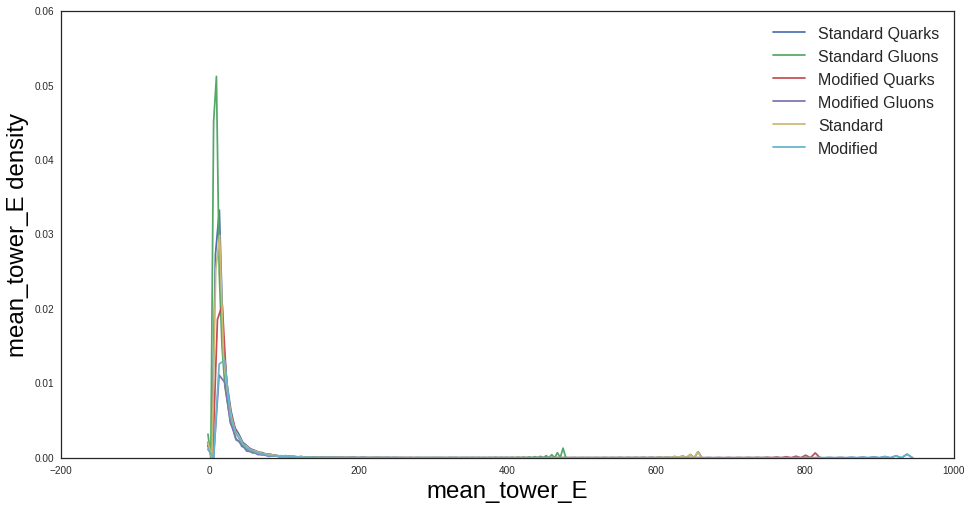

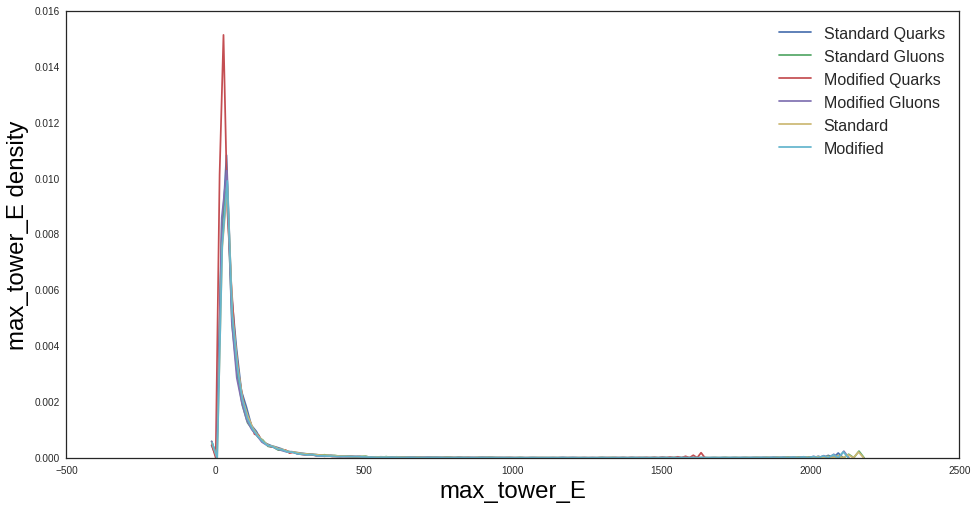

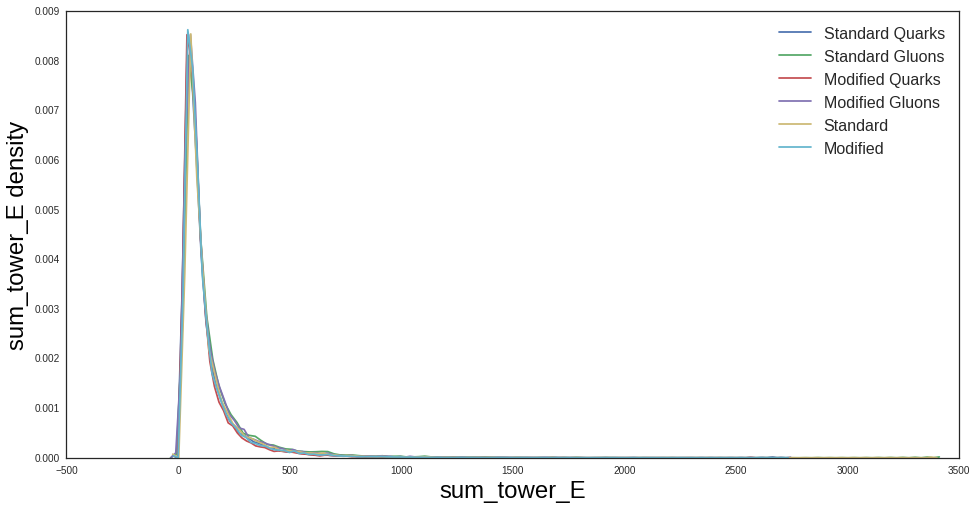

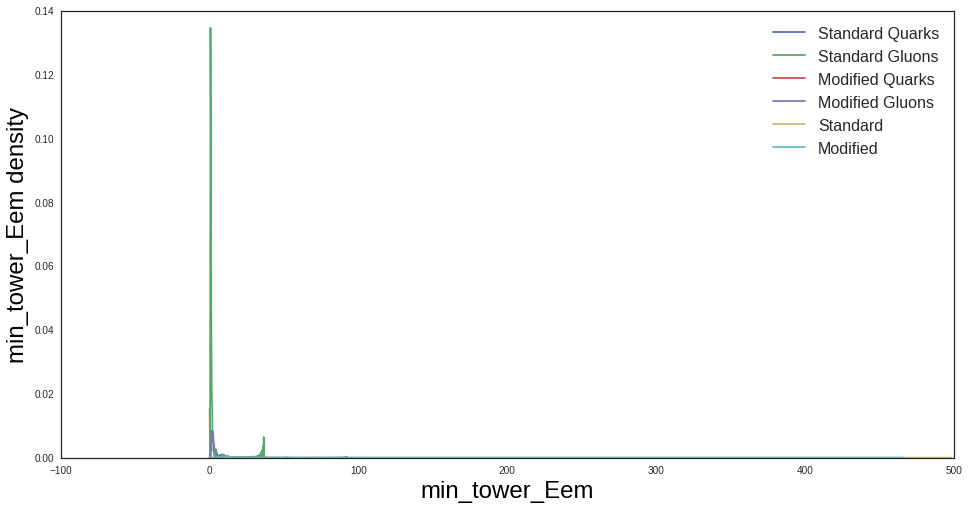

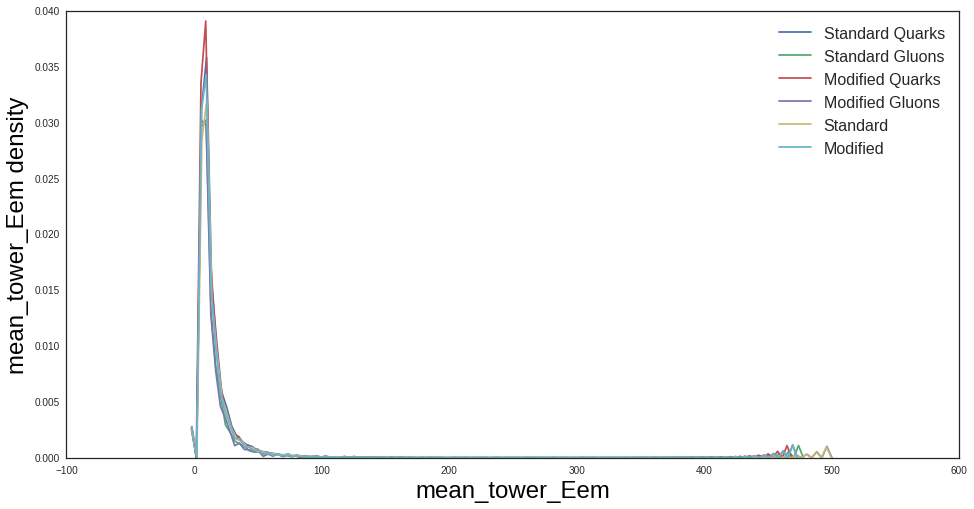

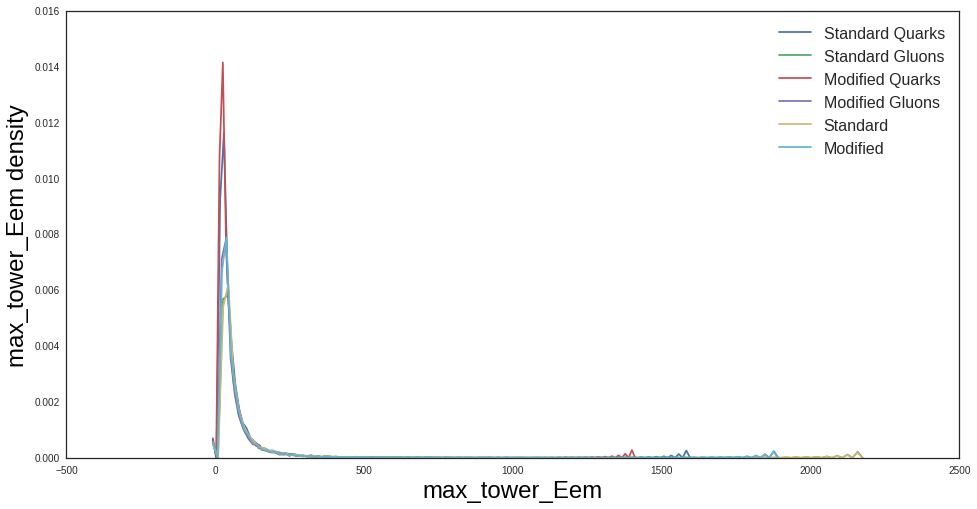

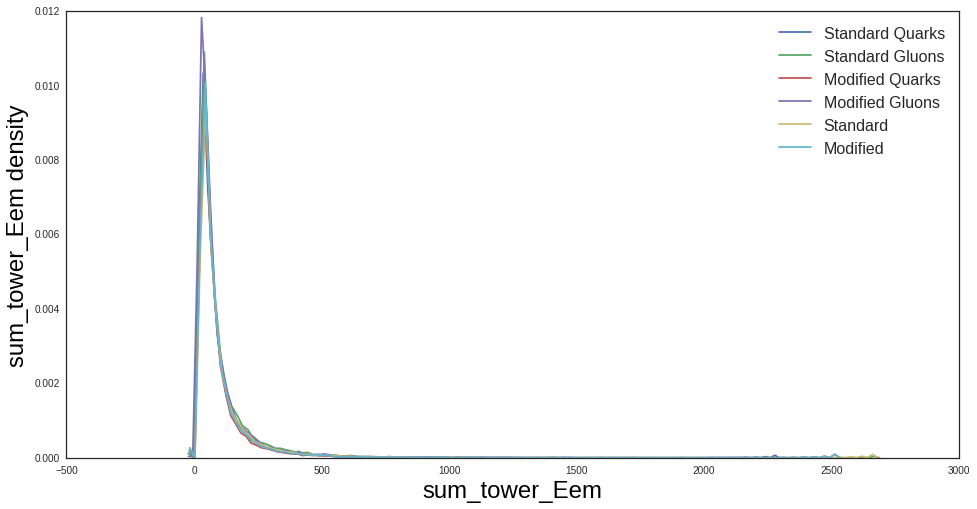

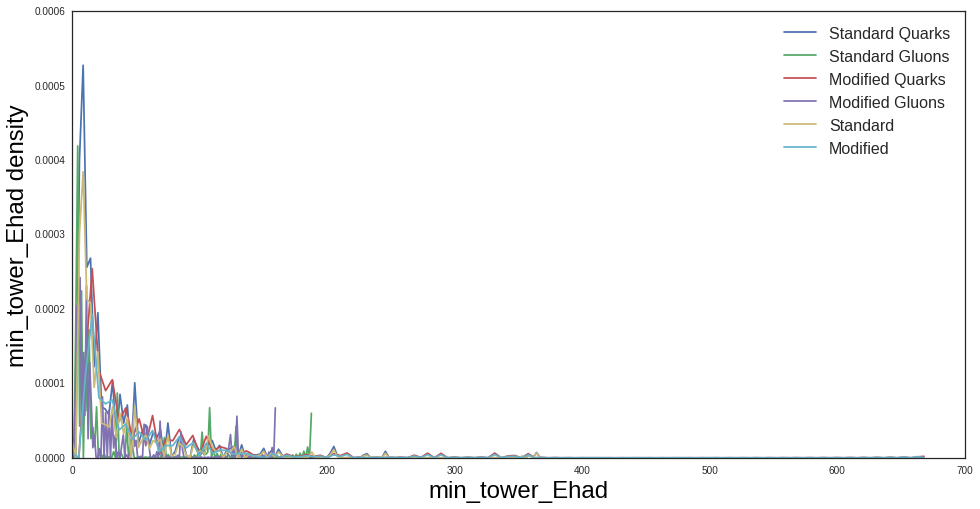

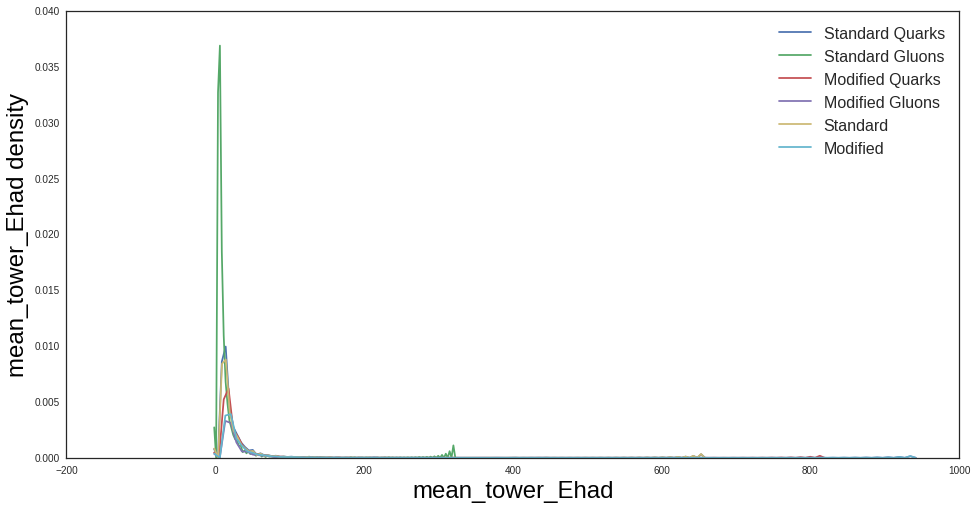

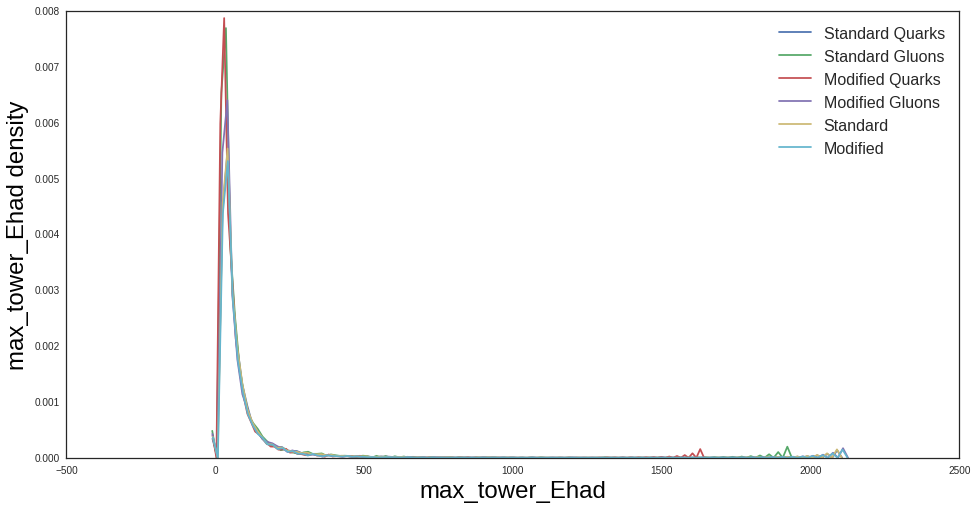

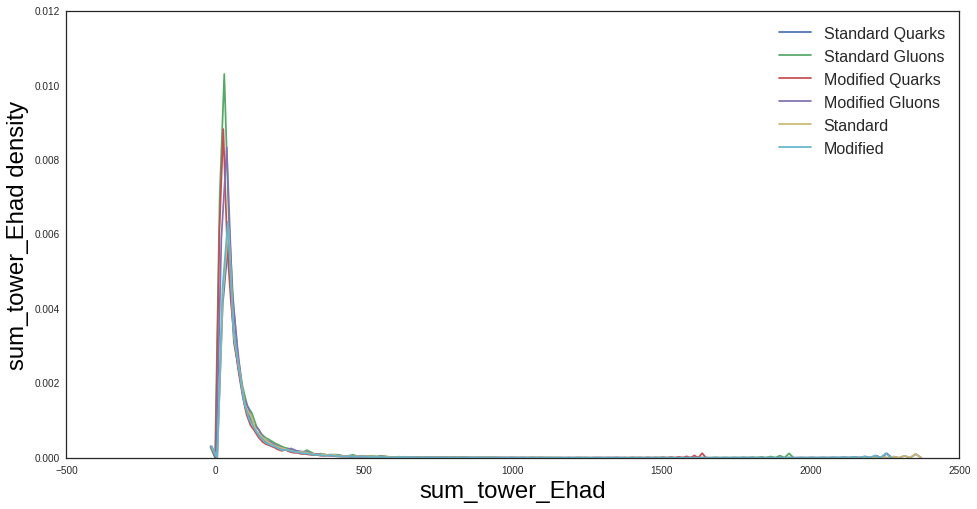

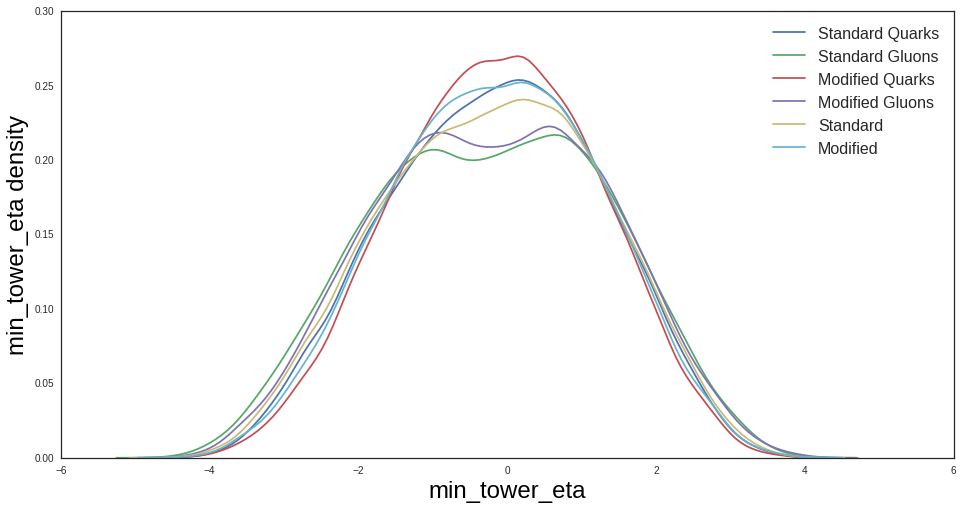

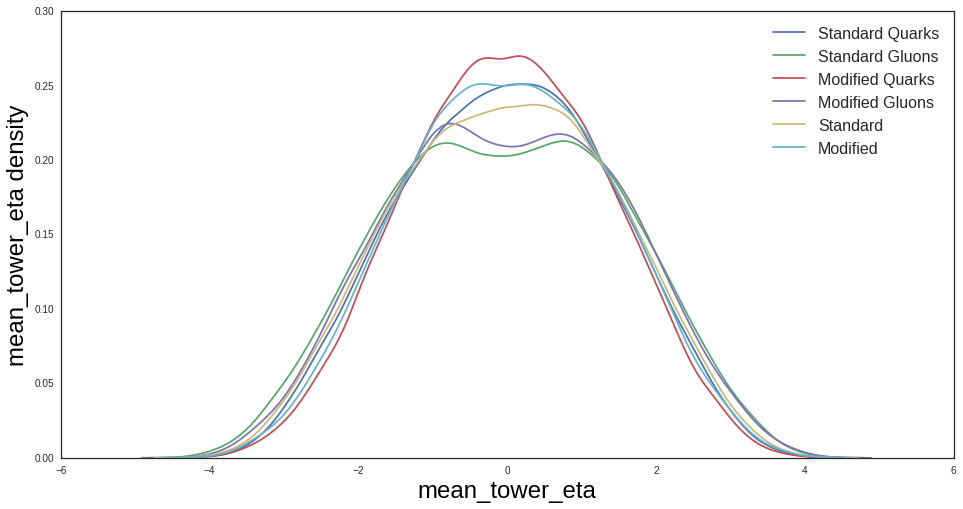

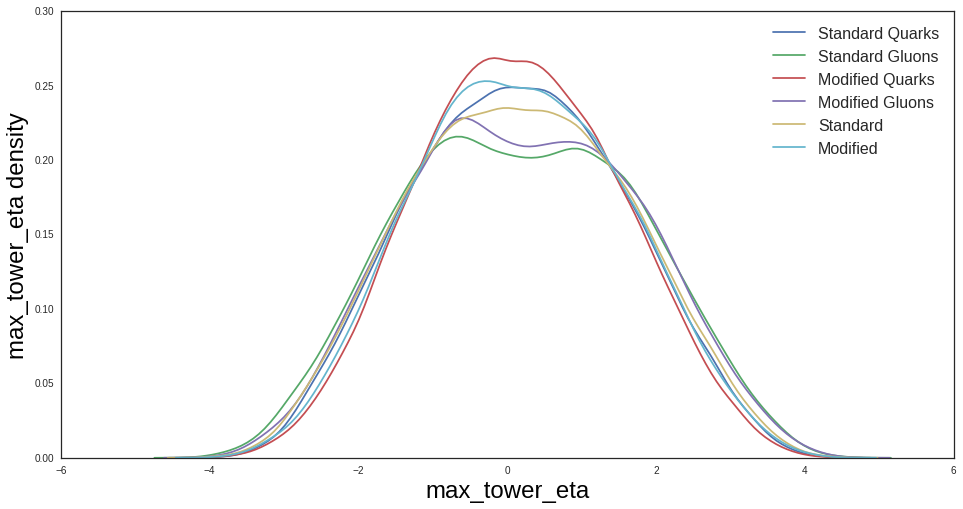

In [15]:
params = {'hist':False}
for var in classTrainFeatures:
        plt.figure(figsize=(16,8))
        sns.distplot(std[std.gen_target == quark][var], label="Standard Quarks", **params)
        sns.distplot(std[std.gen_target == gluon][var], label="Standard Gluons", **params)
        sns.distplot(mod[mod.gen_target == quark][var], label="Modified Quarks", **params)
        sns.distplot(mod[mod.gen_target == gluon][var], label="Modified Gluons", **params)
        sns.distplot(std[var], label="Standard", **params)
        sns.distplot(mod[var], label="Modified", **params)
        plt.legend(loc='best', fontsize=16)
        plt.xlabel(var, fontsize=24, color='black')
        plt.ylabel(var + " density", fontsize=24, color='black')
        plt.show()

## Define classifier

In [16]:
def getDefinedClassifier(params={}):
    classModel = XGBoostClassifier(**params)
    return classModel

## Preprocess data

In [17]:
data = loadPairData("standard", 20000)

In [18]:
print len(data)

64569


In [19]:
stepsIn = []
if not normIn and not pca:
    stepsIn.append(('ident', StandardScaler(with_mean=False, with_std=False))) #For compatability
else:
    if normIn:
        stepsIn.append(('normIn', StandardScaler()))
    if pca:
        stepsIn.append(('pca', PCA(whiten=whiten)))
inputPipe = Pipeline(stepsIn)
inputPipe.fit(loadPairData("standard", 20000)[classTrainFeatures].values.astype('float64'))

Pipeline(steps=[('normIn', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False))])

### Visualise data after pre-processing

In [20]:
std = loadPairData("standard", 20000)[classTrainFeatures].values.astype('float64')
mod = loadPairData("modified", 20000)[classTrainFeatures].values.astype('float64')

In [21]:
std = inputPipe.transform(std)
mod = inputPipe.transform(mod)

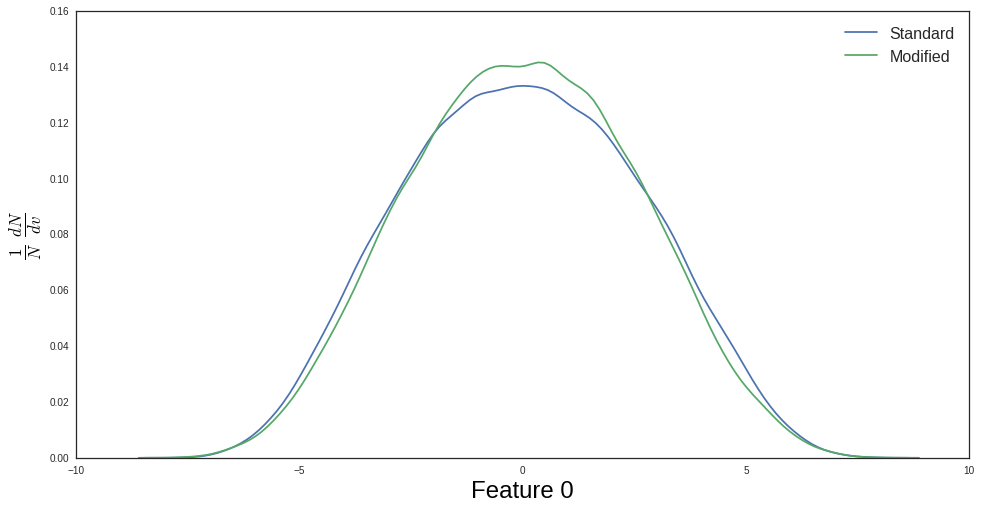

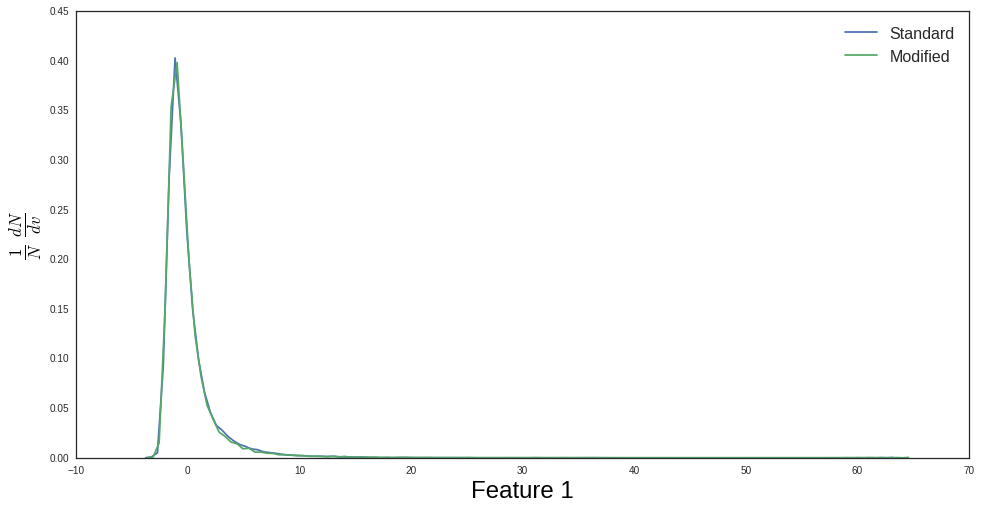

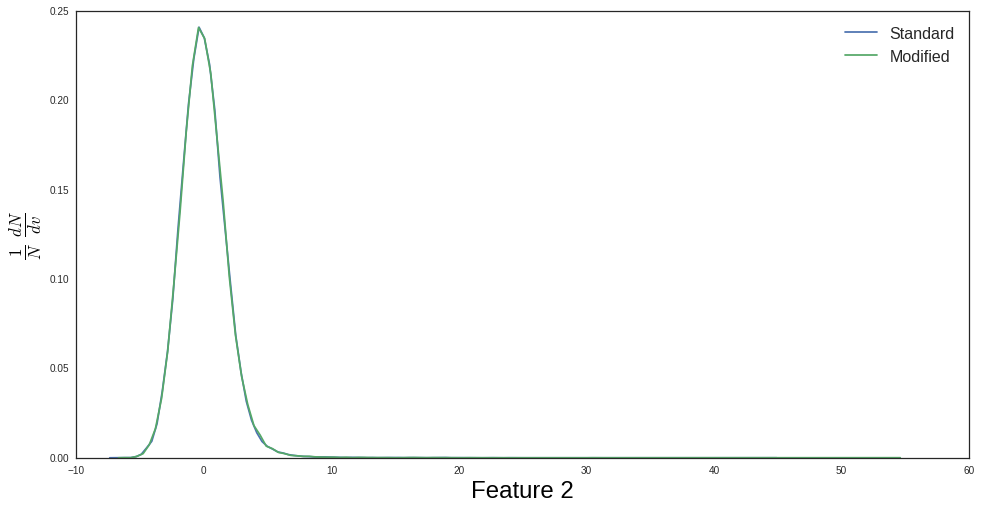

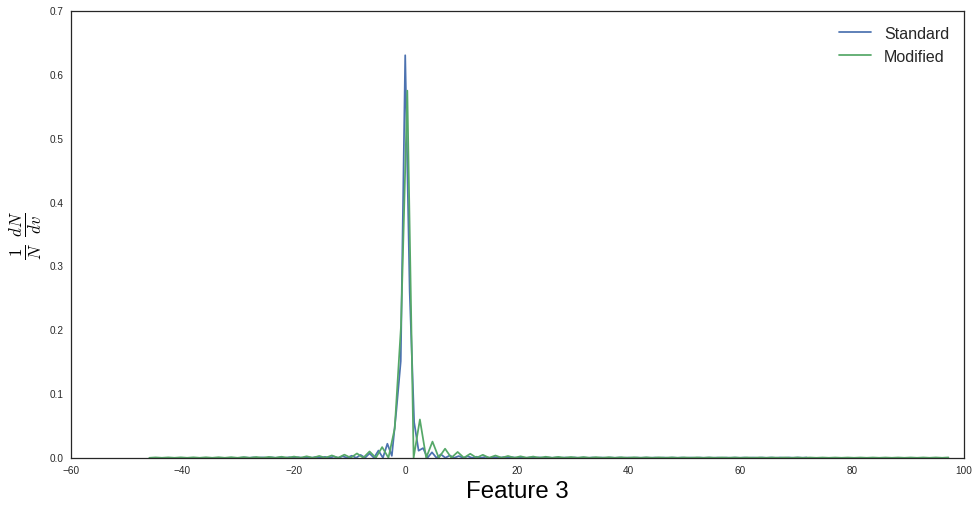

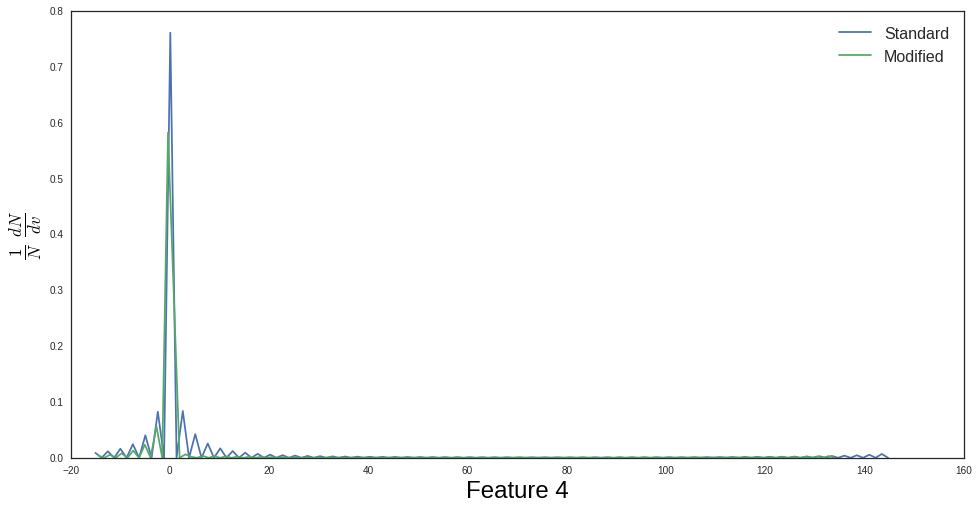

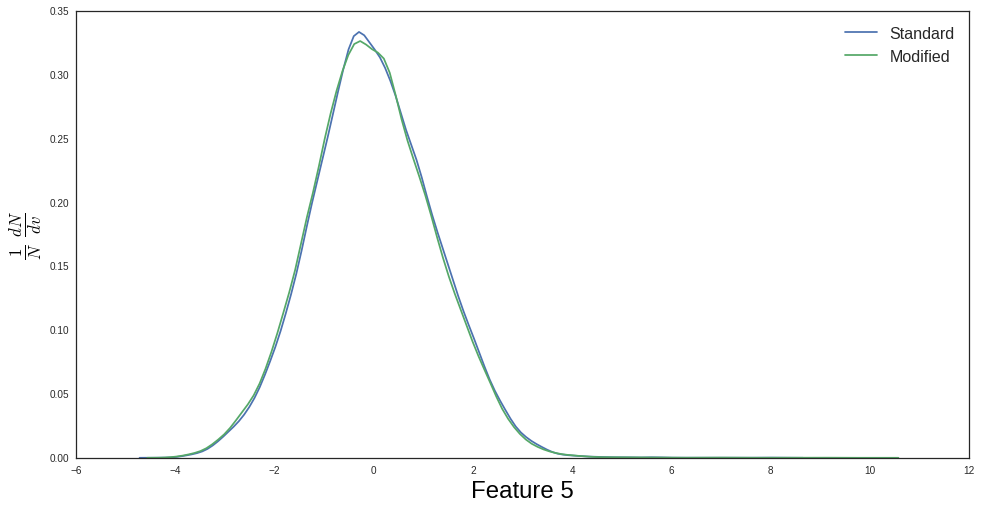

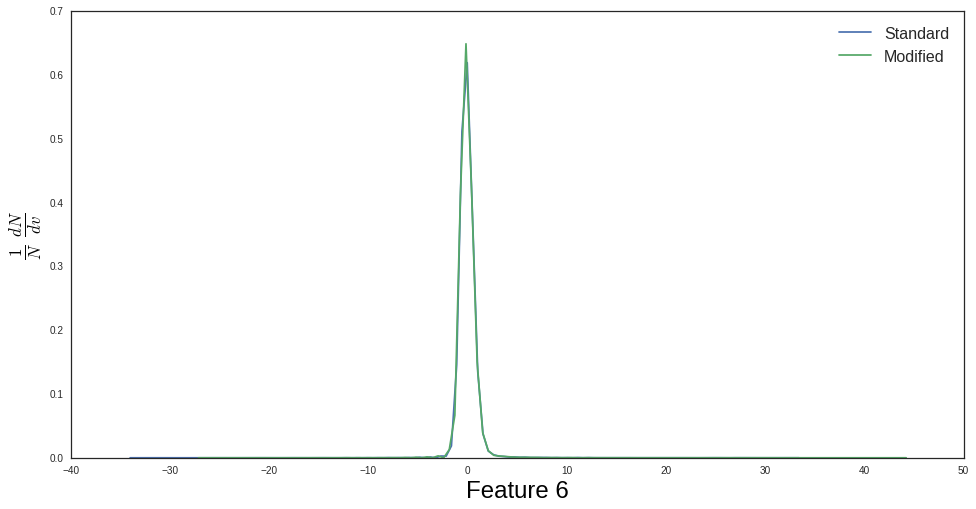

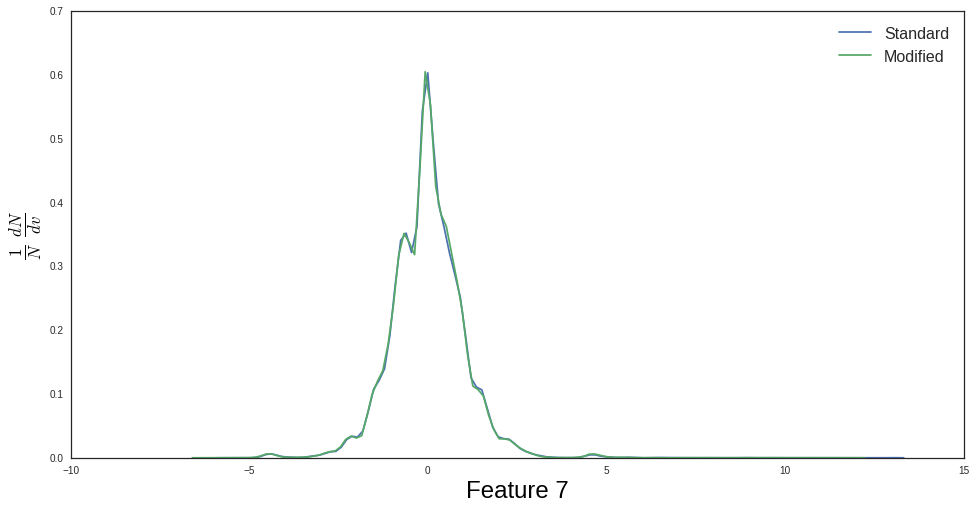

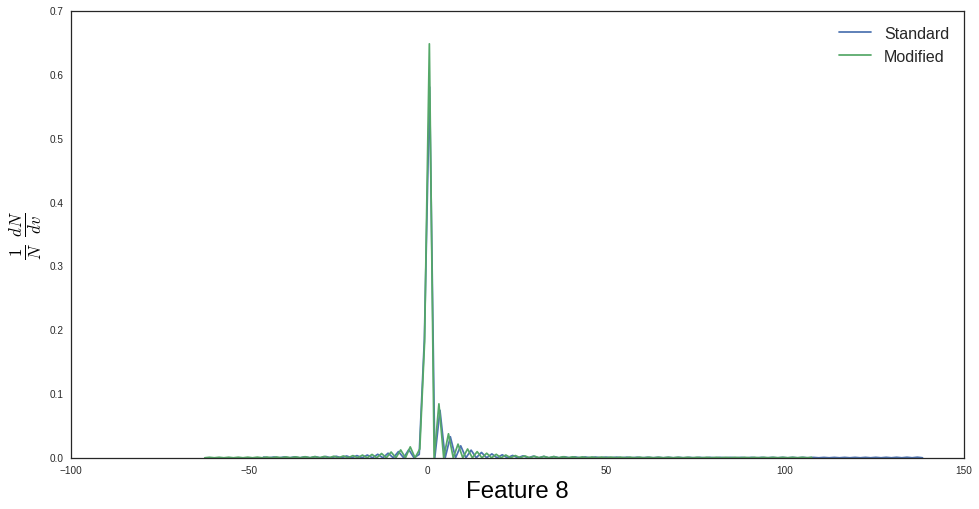

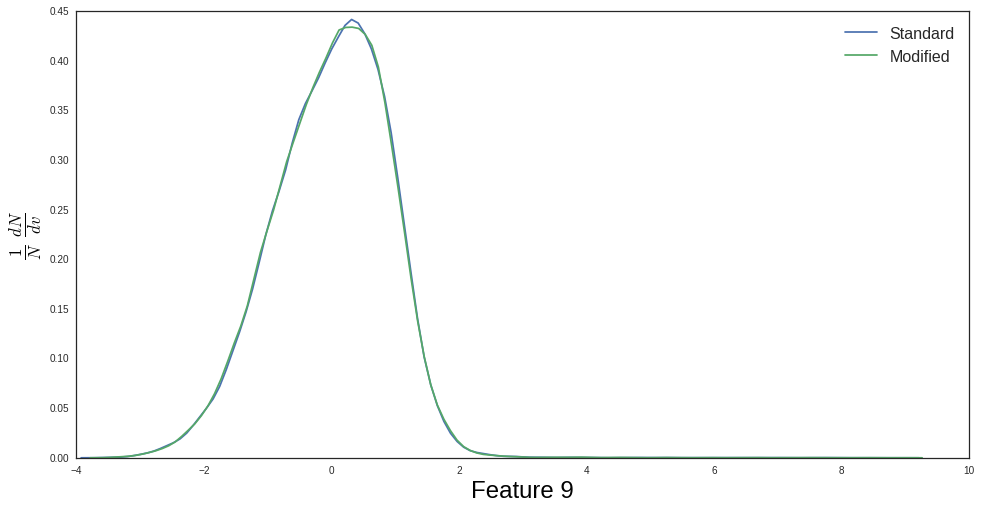

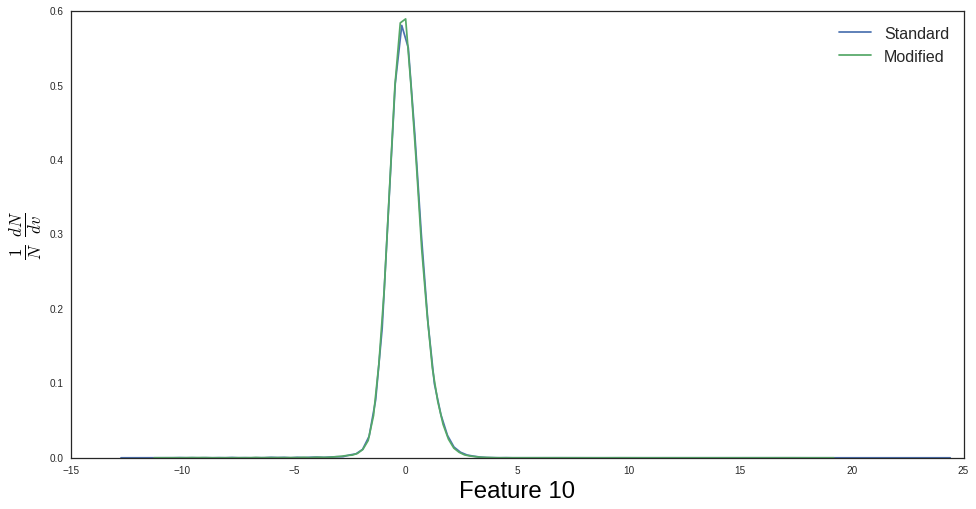

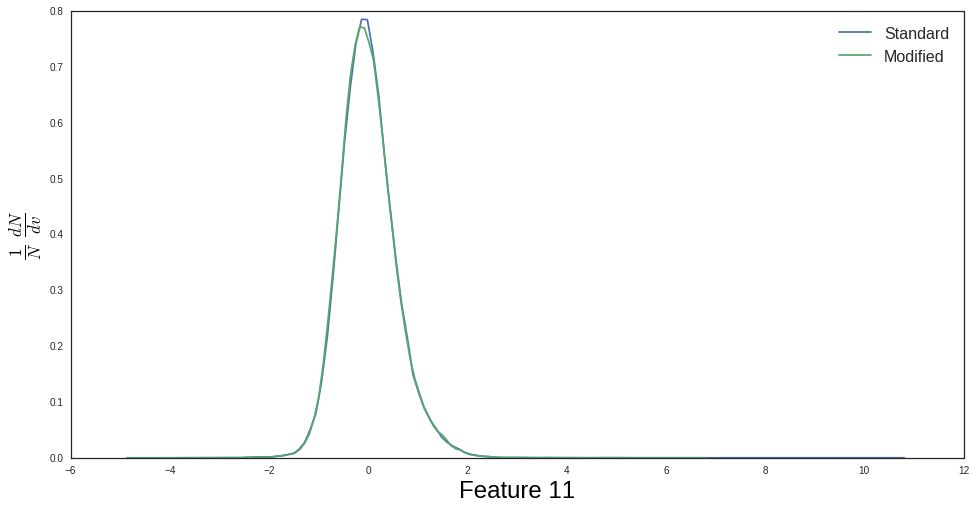

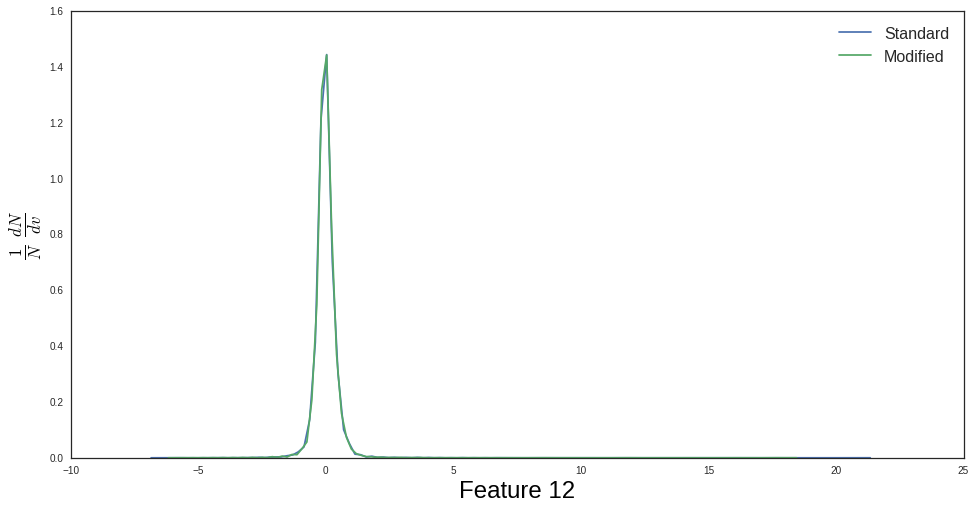

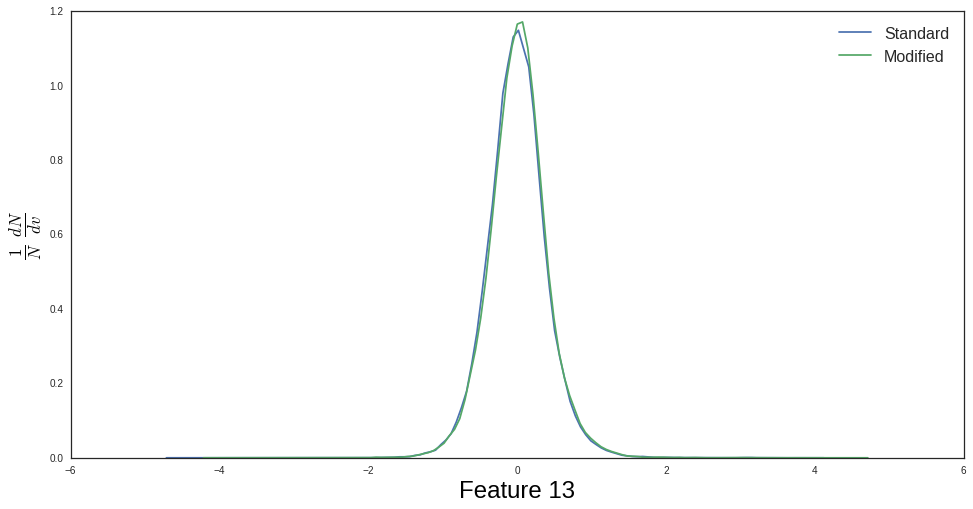

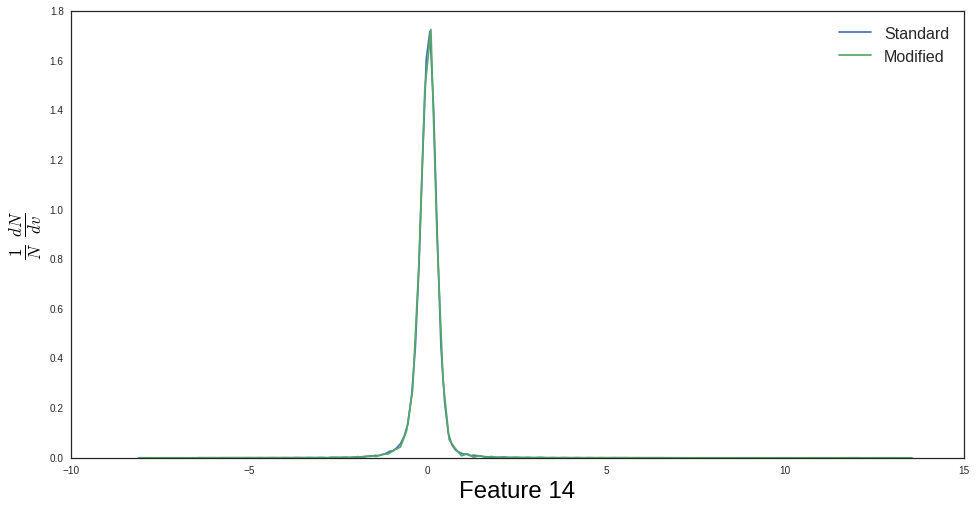

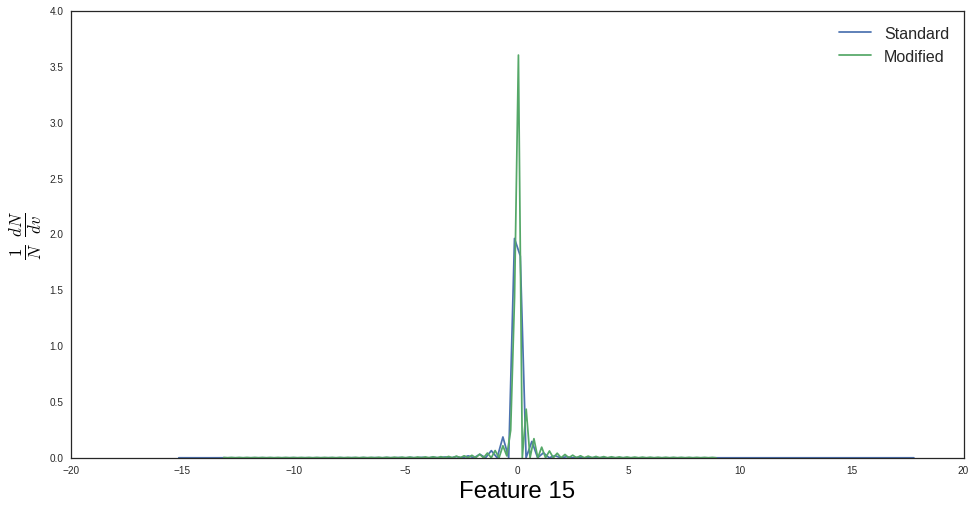

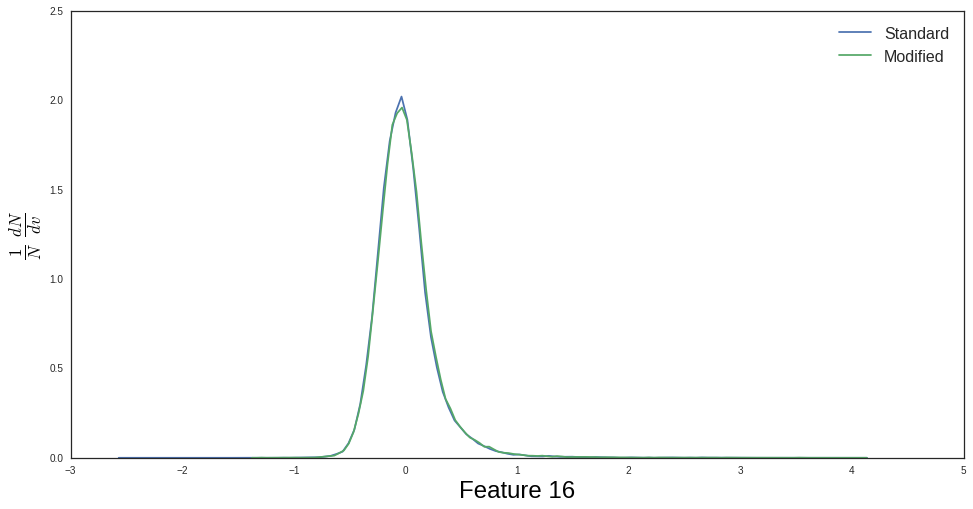

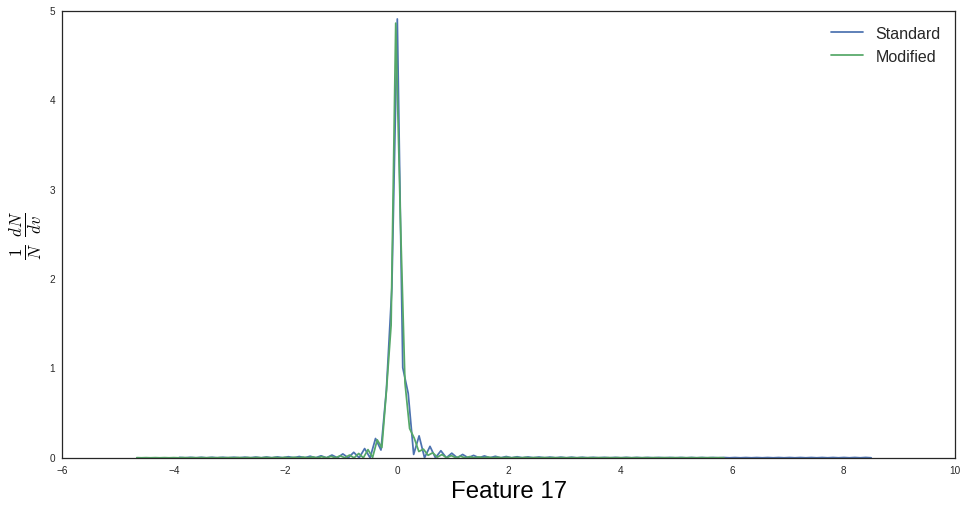

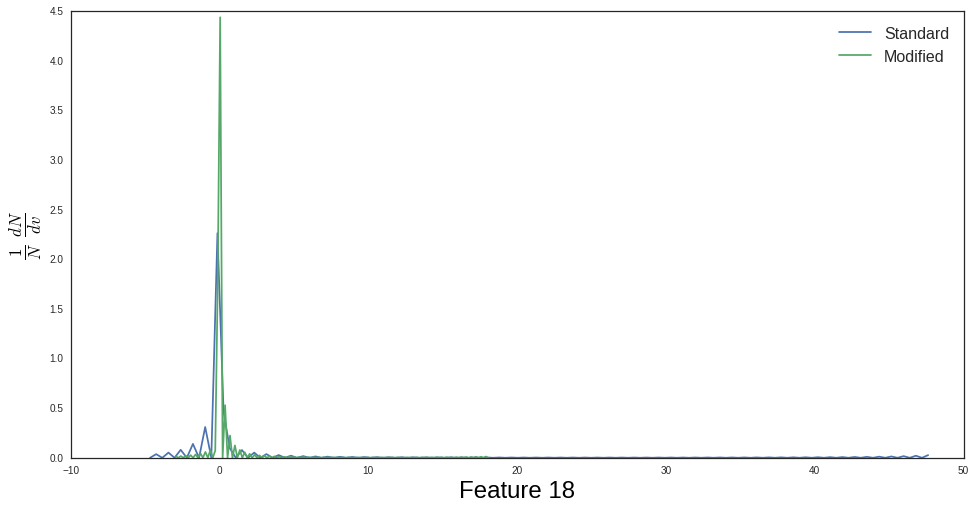

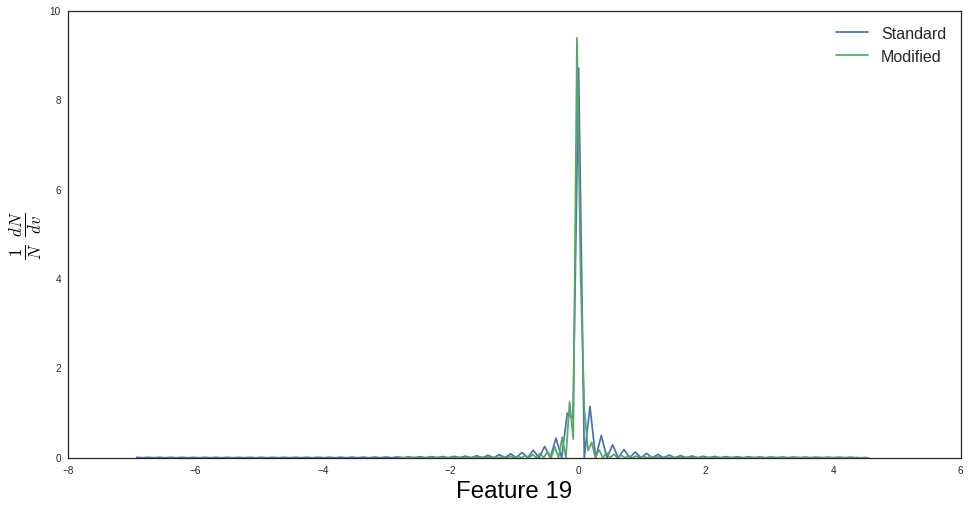

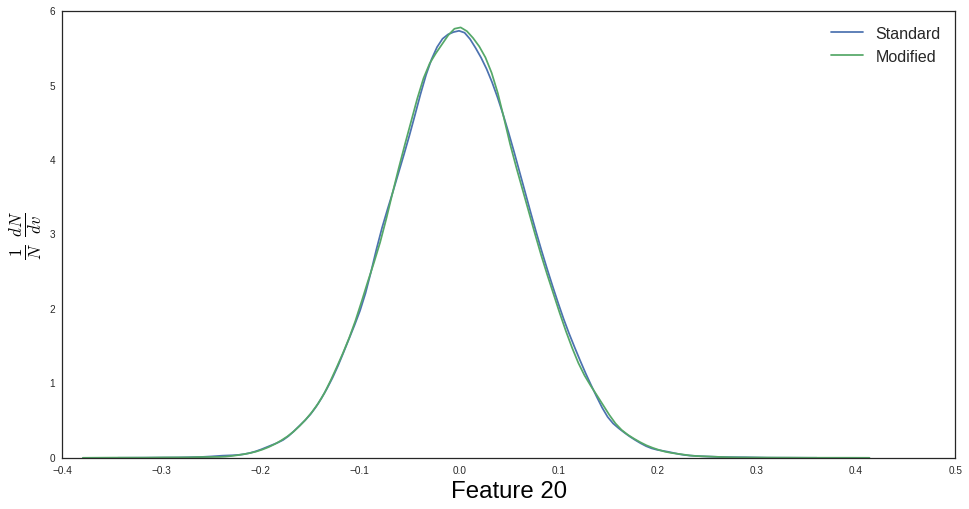

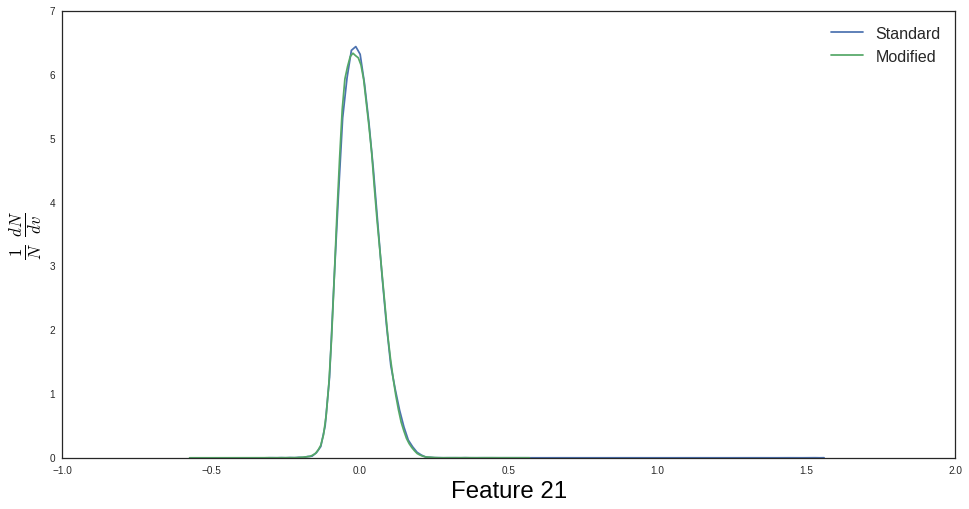

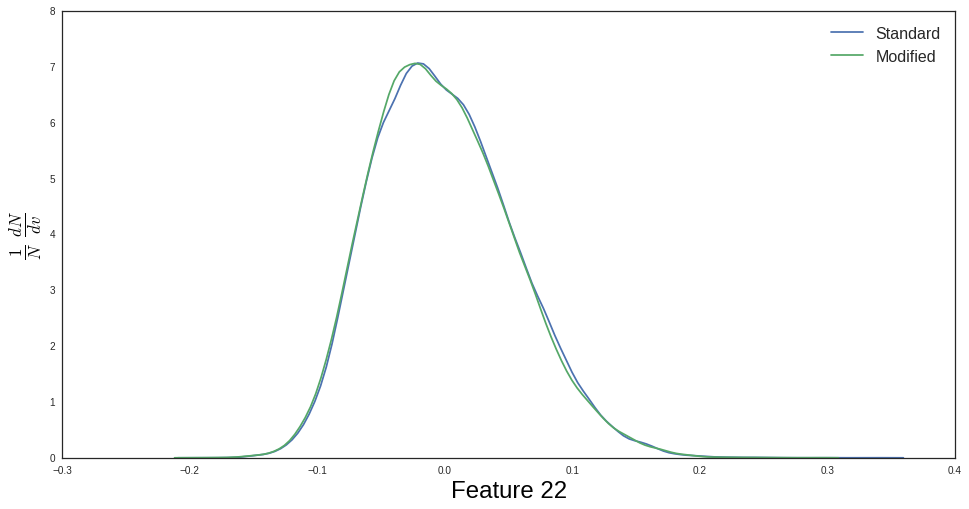

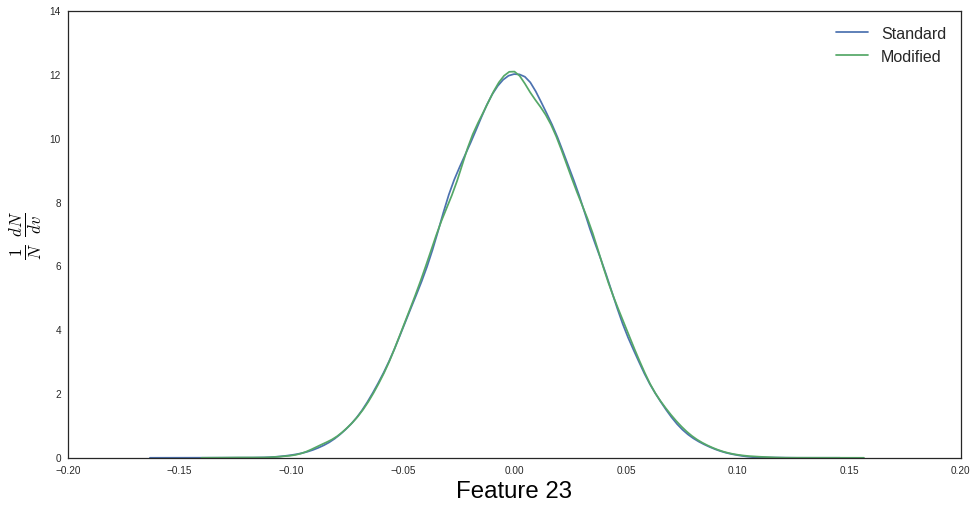

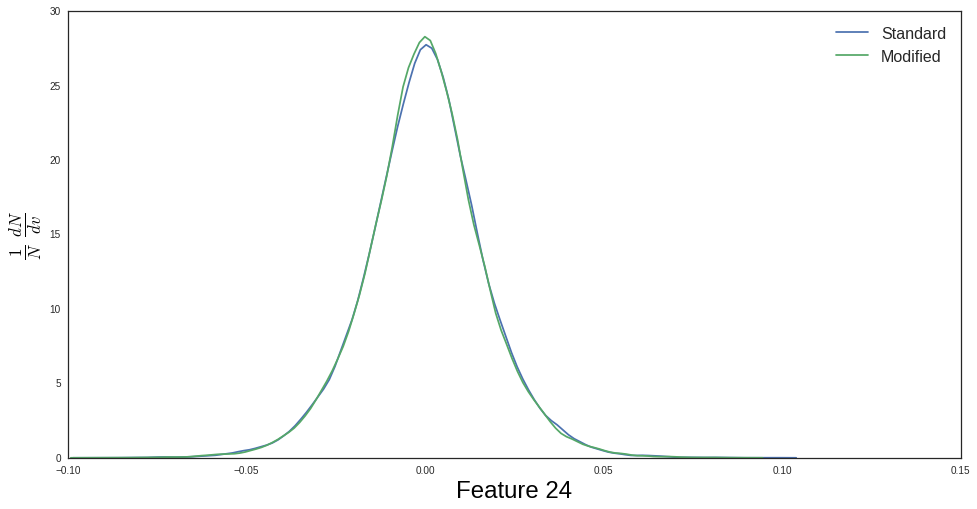

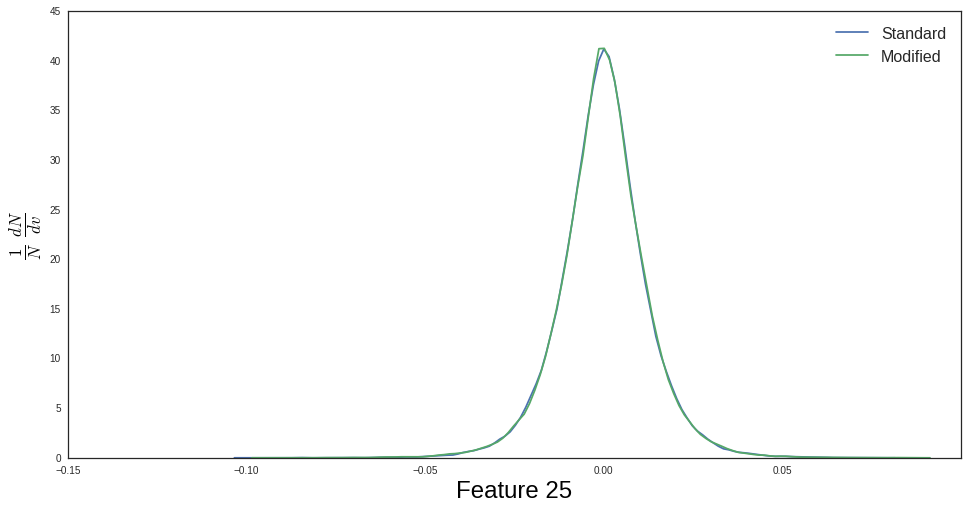

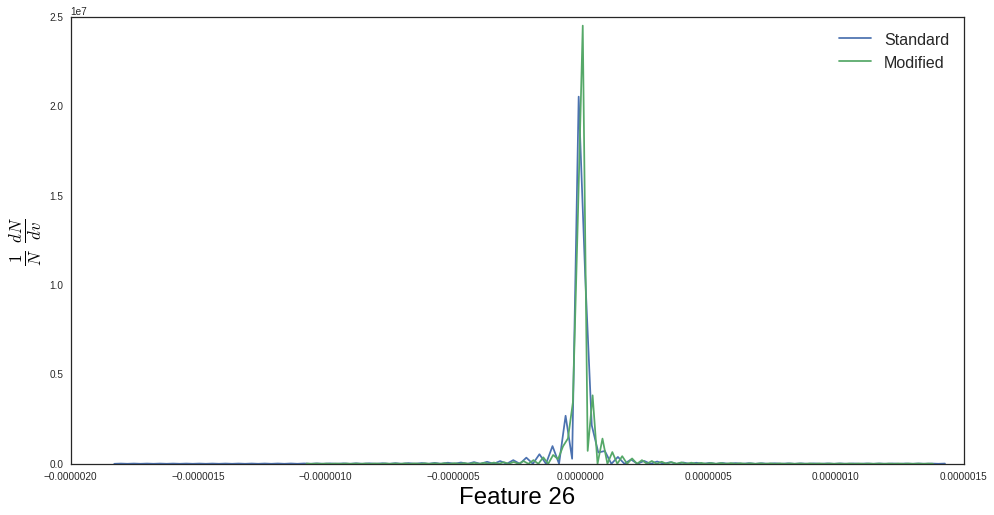

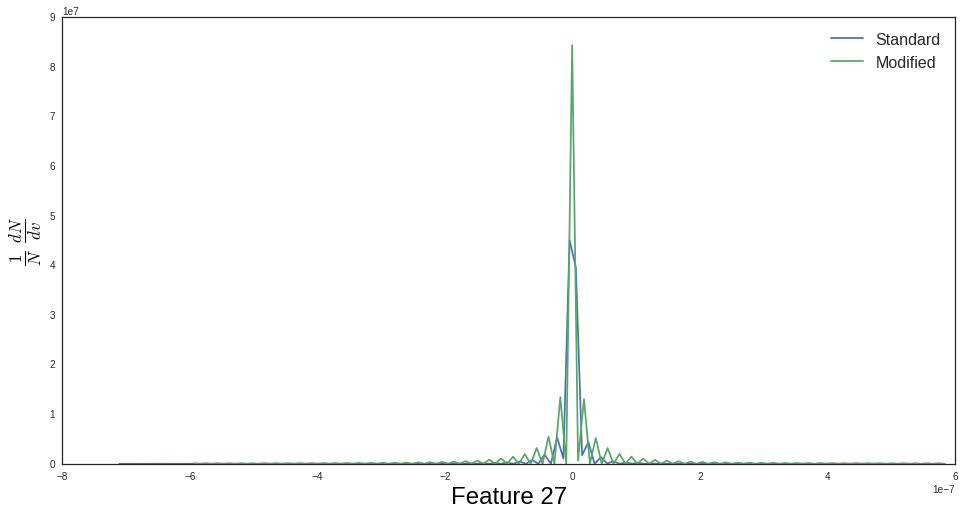

In [22]:
params = {'hist':False}
for i in range(len(classTrainFeatures)):
    try:
        plt.figure(figsize=(16,8))
        sns.distplot(std[:,i], label="Standard", **params)
        sns.distplot(mod[:,i], label="Modified", **params)
        plt.xlabel("Feature " + str(i))
        plt.legend(loc='best', fontsize=16)
        plt.xlabel("Feature " + str(i), fontsize=24, color='black')
        plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{dv}$", fontsize=24, color='black')
        plt.show()
    except:
        continue

## Evaluation

### Cross-validate classifier

In [23]:
start = time.time()
results = []
classifiers = []
for i in range(nSplits):
    print "\nRunning fold", i+1, "/", nSplits
    model = None # Clearing the NN.
    model = getDefinedClassifier()
    data = loadPairData("standard", 10000)
    X_train = inputPipe.transform(data[classTrainFeatures].values.astype('float64'))
    y_train = data["gen_target"].values.astype('int')
    model.fit(X_train, y_train)
    data = loadPairData("standard", 10000)
    X_test = inputPipe.transform(data[classTrainFeatures].values.astype('float64'))
    y_test = data["gen_target"].values.astype('int')
    pred = model.predict_proba(X_test)[:,1]
    score = roc_auc_score(y_test, pred)
    results.append(score)
    classifiers.append(model)
    print "Score is:", score
print "\nCross-validation took {:.3f}s ".format(time.time() - start)
print "Mean score is", np.mean(results), "+-", np.std(results)/math.sqrt(len(results))


Running fold 1 / 10
Score is: 0.77397156122

Running fold 2 / 10
Score is: 0.767956513604

Running fold 3 / 10
Score is: 0.771312640373

Running fold 4 / 10
Score is: 0.767910290641

Running fold 5 / 10
Score is: 0.772483081582

Running fold 6 / 10
Score is: 0.771613059471

Running fold 7 / 10
Score is: 0.769972597471

Running fold 8 / 10
Score is: 0.770938440095

Running fold 9 / 10
Score is: 0.766001434665

Running fold 10 / 10
Score is: 0.774458616877

Cross-validation took 189.415s 
Mean score is 0.7706618236 +- 0.000819608475144


## Construct ensemble

In [24]:
def getWeights(score):
    return 1-score

In [25]:
ensemble = []
weights = []
dtype = [('cycle', int), ('result', float)]
values = np.sort(np.array([(i, result) for i, result in enumerate(results)], dtype=dtype),
                 order=['result'])
for i in range(min([ensembleSize, len(results)])):
    ensemble.append(classifiers[values[len(values)-1-i]['cycle']]) #This is gross
    weights.append(getWeights(values[len(values)-1-i]['result']))
    print "Model", i, "is", values[len(values)-1-i]['cycle'], "with ROC AUC =", values[len(values)-1-i]['result']
weights = np.array(weights)
weights = weights/weights.sum() #normalise weights

Model 0 is 9 with ROC AUC = 0.774458616877
Model 1 is 0 with ROC AUC = 0.77397156122
Model 2 is 4 with ROC AUC = 0.772483081582
Model 3 is 5 with ROC AUC = 0.771613059471
Model 4 is 2 with ROC AUC = 0.771312640373
Model 5 is 7 with ROC AUC = 0.770938440095
Model 6 is 6 with ROC AUC = 0.769972597471
Model 7 is 1 with ROC AUC = 0.767956513604
Model 8 is 3 with ROC AUC = 0.767910290641
Model 9 is 8 with ROC AUC = 0.766001434665


## Response of best model on validation data

### Preprocess data

In [26]:
valData = loadPairData("standard", 40000)
X_val = inputPipe.transform(valData[classTrainFeatures].values.astype("float64"))

### Get Response

In [27]:
valPred = np.zeros((len(X_val)))
for i, model in enumerate(ensemble):
    pred = model.predict_proba(X_val)[:,1]
    valPred += weights[i]*pred 

In [28]:
valData['pred_class'] = pandas.Series(valPred, index=valData.index)

### ROC curve

In [29]:
scoreBootVal = []
scoreBootDev = []
for i in range(100):
    points = np.random.choice(valData.index.tolist(), len(valData), replace=True)
    scoreBootVal.append(roc_auc_score(
            valData.loc[points]['gen_target'].values,
            valData.loc[points]['pred_class'].values))

In [30]:
meanValScore = (np.mean(scoreBootVal), np.std(scoreBootVal)/math.sqrt(len(scoreBootVal)))
print 'Val ROC AUC, Mean = {} +- {}'.format(meanValScore[0], meanValScore[1])

Val ROC AUC, Mean = 0.794302102814 +- 0.000133147371705


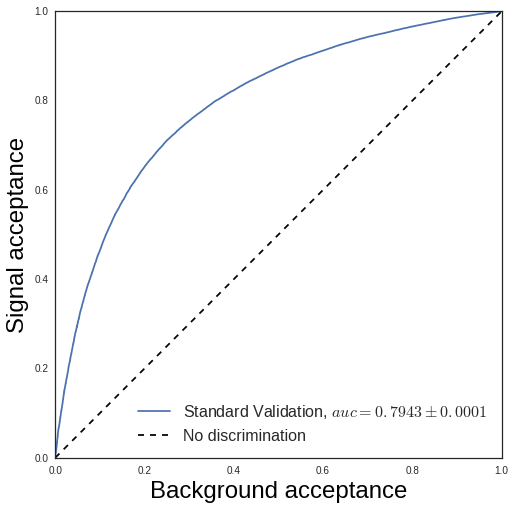

In [31]:
plt.figure(figsize=[8, 8])
plt.plot(*roc_curve(valData['gen_target'].values, valPred)[:2],
         label=r'Standard Validation, $auc={:.4f}\pm{:.4f}$'.format(meanValScore[0], meanValScore[1]))
plt.plot([0, 1], [0, 1], 'k--', label='No discrimination')
plt.xlabel('Background acceptance', fontsize=24, color='black')
plt.ylabel('Signal acceptance', fontsize=24, color='black')
plt.legend(loc='best', fontsize=16)
plt.show()

### MVA distributions

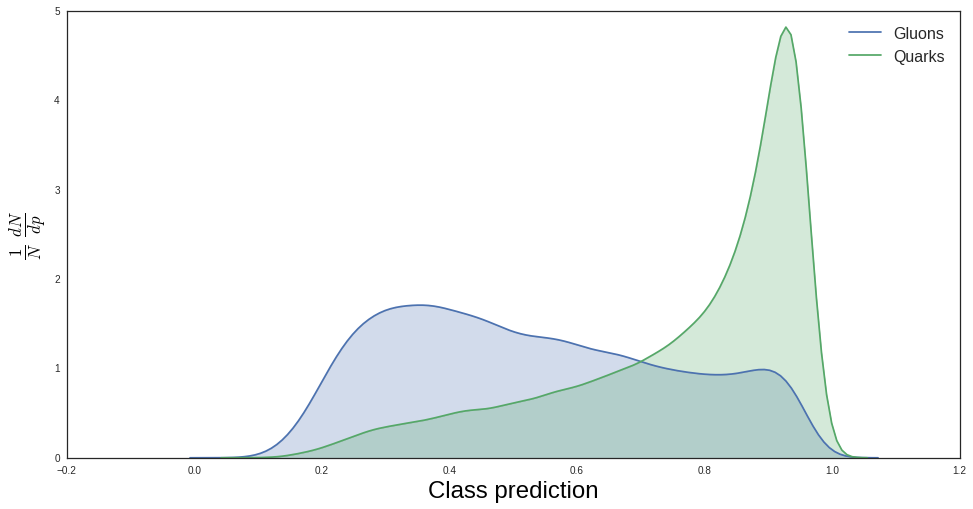

In [32]:
params = {'hist' : False, 'kde' : True, 'rug' : False, 'norm_hist' : True,
          'kde_kws' : {'shade' : True,  'clip' : [0,1], 'bw' : 'scott'}}
plt.figure(figsize=(16, 8))
min_value = 0
max_value = 1
sns.distplot(valData[valData.gen_target == 0]['pred_class'], label='Gluons', **params)
sns.distplot(valData[valData.gen_target == 1]['pred_class'], label='Quarks', **params)
plt.legend(loc='best', fontsize=16)
plt.xlabel("Class prediction", fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{dp}$", fontsize=24, color='black')
#plt.yscale('log', nonposy='clip')
plt.show()

## Run classifier on modified data

### Preprocess data

In [33]:
valData = loadPairData("modified", 40000)
X_val = inputPipe.transform(valData[classTrainFeatures].values.astype("float64"))

### Get Response

In [34]:
valPred = np.zeros((len(X_val)))
for i, model in enumerate(ensemble):
    pred = model.predict_proba(X_val)[:,1]
    valPred += weights[i]*pred 

In [35]:
valData['pred_class'] = pandas.Series(valPred, index=valData.index)

### ROC curve

In [36]:
scoreBootVal = []
scoreBootDev = []
for i in range(100):
    points = np.random.choice(valData.index.tolist(), len(valData), replace=True)
    scoreBootVal.append(roc_auc_score(
            valData.loc[points]['gen_target'].values,
            valData.loc[points]['pred_class'].values))

In [37]:
meanValScore = (np.mean(scoreBootVal), np.std(scoreBootVal)/math.sqrt(len(scoreBootVal)))
print 'Val ROC AUC, Mean = {} +- {}'.format(meanValScore[0], meanValScore[1])

Val ROC AUC, Mean = 0.787943990785 +- 0.000136739945029


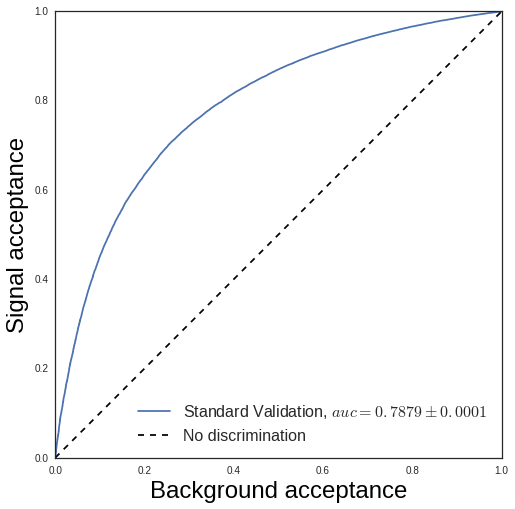

In [38]:
plt.figure(figsize=[8, 8])
plt.plot(*roc_curve(valData['gen_target'].values, valPred)[:2],
         label=r'Standard Validation, $auc={:.4f}\pm{:.4f}$'.format(meanValScore[0], meanValScore[1]))
plt.plot([0, 1], [0, 1], 'k--', label='No discrimination')
plt.xlabel('Background acceptance', fontsize=24, color='black')
plt.ylabel('Signal acceptance', fontsize=24, color='black')
plt.legend(loc='best', fontsize=16)
plt.show()

### MVA distributions

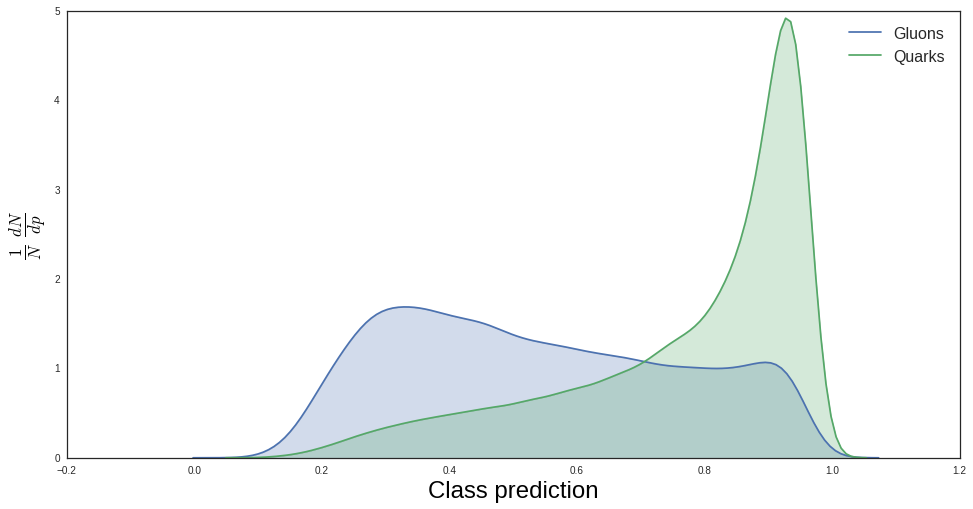

In [39]:
params = {'hist' : False, 'kde' : True, 'rug' : False, 'norm_hist' : True,
          'kde_kws' : {'shade' : True,  'clip' : [0,1], 'bw' : 'scott'}}
plt.figure(figsize=(16, 8))
min_value = 0
max_value = 1
sns.distplot(valData[valData.gen_target == 0]['pred_class'], label='Gluons', **params)
sns.distplot(valData[valData.gen_target == 1]['pred_class'], label='Quarks', **params)
plt.legend(loc='best', fontsize=16)
plt.xlabel("Class prediction", fontsize=24, color='black')
plt.ylabel(r"$\frac{1}{N}\ \frac{dN}{dp}$", fontsize=24, color='black')
#plt.yscale('log', nonposy='clip')
plt.show()

## Run over all modified data

In [42]:
runOnAll = True

### Predict classes

In [77]:
def predictClass(f, ensemble, v=0):
    if v: print "Predicting file", f
    data = pandas.DataFrame(root_numpy.root2array(f, treename = "treeJets"))
    data = data[(data.ntracks > 0) & (data.ntowers > 0)].copy()
    mode = 'quarks'
    if "gluons" in f.lower():
        mode = 'gluons'
    processData(data, mode)
    X = inputPipe.transform(data[classTrainFeatures].values.astype("float64"))
    fPred = np.zeros((len(X)))
    for i, model in enumerate(ensemble):
        pred = model.predict_proba(X)[:,1]
        fPred += weights[i]*pred
    data['pred_class'] = pandas.Series(fPred, index=data.index)
    data[['gen_target', 'pred_class']].to_csv('results/' + f[f.rfind("/"):f.rfind(".root")] + '.csv')

In [79]:
if runOnAll:
    modifiedGluons = "../../IMLChallengeQG/gluons_modified/"
    modifiedQuarks = "../../IMLChallengeQG/quarks_modified/"
    start = time.time()
    '''for f in glob.glob(modifiedGluons + "*.root"):
        predictClass(f, ensemble, 0)
    print time.time()-start, "seconds to predict gluons"'''
    start = time.time()
    for f in glob.glob(modifiedQuarks + "*.root"):
        predictClass(f, ensemble, 0)
    print time.time()-start, "seconds to predict quarks"

517.679533005 seconds to predict quarks


### Combine predictions and score

In [80]:
data = pandas.concat((pandas.read_csv(f) for f in glob.glob('results/*.csv')))

In [82]:
score = roc_auc_score(
            data['gen_target'].values.astype('int'),
            data['pred_class'].values.astype('float64'))
print score

0.78885370968


## Results

- classTrainFeatures = set1
- classTrainModel = "model0"
- normIn = True
- pca = True
- whiten = True
- ratios = True
- nSplits = 10
- ensembleSize = 10
- Val AUC Mean = 0.794327966965 +- 0.000139510257584
- Mod AUC Mean = 0.788236432458 +- 0.000133980529766
- 
- classTrainFeatures = set1
- classTrainModel = "model0"
- normIn = True
- pca = True
- whiten = False
- ratios = True
- nSplits = 10
- ensembleSize = 10
- Val AUC Mean = 0.794404450044 +- 0.000134667646006
- Mod AUC Mean = 0.788006079955 +- 0.000130686987289